# **0. ENMARCAR EL PROBLEMA**

## Objetivo del proyecto
El objetivo es desarrollar un modelo de riesgo de crédito capaz de estimar la probabilidad de impago (Probability of Default, PD) para solicitudes de préstamo del dataset Home Credit Default Risk.  
El propósito es mejorar la discriminación entre clientes buenos y malos y apoyar decisiones de concesión de crédito.
El scoring crediticio es un componente fundamental en los procesos de originación, ya que permite estandarizar las decisiones, reducir la exposición a impagos y optimizar el ciclo de aprobación. Un sistema basado en probabilidades ofrece una estimación continua del riesgo, proporcionando una base sólida para definir políticas de aprobación, límites de endeudamiento y condiciones del préstamo.

## Tipo de problema
Aprendizaje supervisado.  
Clasificación binaria.  
Salida esperada: score probabilístico (probabilidad de impago).

## Variable objetivo
TARGET = 1: solicitud que terminó en impago.  
TARGET = 0: solicitud que no terminó en impago.  

## Uso esperado del modelo
El score producido por el modelo se utilizará para priorizar riesgos, establecer umbrales de aprobación y ajustar condiciones del préstamo según el perfil del cliente.  
El modelo complementa las reglas de negocio existentes.

## Métricas principales
Se utilizarán tres métricas estándar del sector crediticio: AUC, Gini y KS.

AUC (Area Under the Curve): mide la capacidad del modelo para ordenar correctamente a clientes buenos y malos en todo el rango de scores. Un AUC mayor indica mejor discriminación global.

Gini: métrica equivalente derivada del AUC mediante la expresión Gini = 2*AUC - 1. Es ampliamente utilizada en scoring crediticio para expresar poder discriminante. Un valor más alto implica mejor capacidad del modelo para separar buenos de malos.

KS (Kolmogorov-Smirnov): mide la máxima separación entre las distribuciones acumuladas de clientes buenos y malos según el score. Un KS más alto indica que el modelo discrimina de forma más clara entre ambos grupos.

Objetivos mínimos razonables para un modelo de originación:
AUC ≥ 0.70  
Gini ≥ 0.40  
KS ≥ 30

## Alcance del proyecto
El proyecto incluirá los siguientes componentes:

1. Carga y revisión inicial de todas las tablas del dataset.  
2. EDA básico sobre la tabla principal (application_train).  
3. Construcción del dataset final mediante agregaciones y uniones con las tablas auxiliares (bureau, bureau_balance, previous_application, POS_CASH_balance, installments_payments y credit_card_balance).  
4. EDA profundo del dataset consolidado, incluyendo análisis univariante, bivariante y correlaciones.  
5. División de datos en train y test antes de cualquier preprocesamiento.  
6. Preprocesamiento completo: imputación, codificación, escalado y construcción del pipeline (ajustado únicamente con train para evitar leakage).  
7. Feature engineering específico del contexto financiero, incluyendo ratios, transformaciones y variables derivadas.  
8. Entrenamiento de varios modelos base (por ejemplo: Regresión Logística, Random Forest, XGBoost, LightGBM y CatBoost) y comparación de rendimiento.  
9. Optimización del mejor modelo mediante búsqueda de hiperparámetros.  
10. Interpretabilidad del modelo final utilizando SHAP.  
11. Evaluación final con métricas de riesgo crediticio.  
12. Conclusiones del proyecto.  
13. Guardado del pipeline y del modelo optimizado.  
14. Ejemplo de uso con datos nuevos (mini deployment).

## Suposiciones del proyecto
Los datos históricos representan razonablemente el comportamiento futuro.  
La información registrada es fiable y está correctamente anonimizada.  
No se utilizará información futura no disponible en el momento de originación.  
Train y test mantienen distribuciones comparables.  
La definición de TARGET es consistente a lo largo del dataset.  
Toda la información utilizada está disponible en el momento de la solicitud de crédito.

## Riesgos y limitaciones
Cambios futuros en el perfil de clientes o en las políticas de crédito pueden alterar el rendimiento del modelo.  
Las tablas externas pueden contener ruido o información incompleta.  
El modelo no captura posibles efectos temporales no presentes en los datos.  
Existen dependencias con la calidad de los merges y las agregaciones.

## Criterios de éxito del proyecto
El proyecto se considerará exitoso si el modelo final cumple los objetivos de discriminación establecidos y si el pipeline completo puede aplicarse de forma reproducible a nuevos datos. Además, el proceso deberá ser trazable, interpretable y alineado con las prácticas habituales en modelización de riesgo de crédito.

## Conclusión de la Fase 0
Esta fase establece el objetivo de negocio, el marco analítico y las métricas clave del proyecto. A partir de aquí se procede a la carga de datos y a la preparación del entorno para iniciar el desarrollo del modelo.


# **1. DESCARGA DE DATOS**

En esta fase preparamos el entorno de trabajo en Google Colab y descargamos el dataset de **Home Credit Default Risk** directamente desde Kaggle mediante su API oficial. Dejamos los ficheros en una carpeta de trabajo (home_credit_data) listos para el EDA y las fases posteriores.


In [ ]:
# Instalación de la librería oficial de Kaggle
!pip install -q kaggle


In [ ]:
from google.colab import files

# Subir el archivo kaggle.json descargado desde la cuenta de Kaggle
uploaded = files.upload()


Saving kaggle.json to kaggle (2).json


In [ ]:
import os

# Configurar credenciales de Kaggle
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Definir competición y carpeta local de datos
COMPETITION = "home-credit-default-risk"
DATA_DIR = "home_credit_data"
os.makedirs(DATA_DIR, exist_ok=True)


In [ ]:
# Descarga del ZIP de la competición en la carpeta DATA_DIR
!kaggle competitions download -c {COMPETITION} -p {DATA_DIR}


home-credit-default-risk.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

# Listar archivos descargados en la carpeta de datos
print("Archivos en el directorio de datos:")
print(os.listdir(DATA_DIR))

zip_path = os.path.join(DATA_DIR, "home-credit-default-risk.zip")

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"No se encontró el ZIP esperado en {zip_path}")

# Descomprimir el contenido del ZIP
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(DATA_DIR)

print("\nDescompresión completada.")
print("Archivos disponibles en 'home_credit_data':")
print(os.listdir(DATA_DIR))


Archivos en el directorio de datos:
['home-credit-default-risk.zip', 'credit_card_balance.csv', 'bureau_balance.csv', 'sample_submission.csv', 'application_test.csv', 'POS_CASH_balance.csv', 'application_train.csv', 'bureau.csv', 'HomeCredit_columns_description.csv', 'previous_application.csv', 'installments_payments.csv']

Descompresión completada.
Archivos disponibles en 'home_credit_data':
['home-credit-default-risk.zip', 'credit_card_balance.csv', 'bureau_balance.csv', 'sample_submission.csv', 'application_test.csv', 'POS_CASH_balance.csv', 'application_train.csv', 'bureau.csv', 'HomeCredit_columns_description.csv', 'previous_application.csv', 'installments_payments.csv']


In [ ]:
files_info = []

for filename in os.listdir(DATA_DIR):
    file_path = os.path.join(DATA_DIR, filename)
    if os.path.isfile(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        files_info.append((filename, size_mb))

print("Resumen de archivos en 'home_credit_data':\n")
for name, size in files_info:
    print(f"{name:40s}  {size:8.2f} MB")


Resumen de archivos en 'home_credit_data':

home-credit-default-risk.zip                688.19 MB
credit_card_balance.csv                     404.91 MB
bureau_balance.csv                          358.19 MB
sample_submission.csv                         0.51 MB
application_test.csv                         25.34 MB
POS_CASH_balance.csv                        374.51 MB
application_train.csv                       158.44 MB
bureau.csv                                  162.14 MB
HomeCredit_columns_description.csv            0.04 MB
previous_application.csv                    386.21 MB
installments_payments.csv                   689.62 MB


# **2. ANÁLISIS EXPLORATORIO DE LOS DATOS (EDA)**

En esta fase realizamos el análisis exploratorio completo de los datos del proyecto.
Empezamos analizando la tabla principal (**application_train**) para evaluar su estructura, calidad y distribución.
Posteriormente examinamos las tablas secundarias, definimos las agregaciones necesarias, integramos la información relevante en la tabla principal y finalizamos con un EDA profundo del dataset completo preparado para el modelado.



## **2.1 Carga y revisión inicial de los datos**

En esta sección realizamos la configuración inicial del entorno, la carga de los datasets
**application_train** y **application_test**, y las primeras comprobaciones fundamentales de estructura:

- Verificación de la existencia de columnas clave.
- Comprobación de unicidad del identificador de cliente.
- Revisión preliminar de tipos de datos y distribución del target.

Estos pasos aseguran que los datasets están correctamente cargados y que la estructura base es consistente antes de avanzar con el análisis exploratorio más profundo.


In [ ]:
# 2.1.1 Configuración inicial e importación de librerías
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42

# 2.1.2 Definición de rutas de datos
DATA_DIR = Path("home_credit_data")
TRAIN_PATH = DATA_DIR / "application_train.csv"
TEST_PATH = DATA_DIR / "application_test.csv"

# 2.1.3 Carga de datos
application_train = pd.read_csv(TRAIN_PATH)
application_test = pd.read_csv(TEST_PATH)

# 2.1.4 Comprobaciones básicas de tamaño
print("Shape train:", application_train.shape)
print("Shape test: ", application_test.shape)

# 2.1.5 Comprobaciones de columnas clave
ID_COL = "SK_ID_CURR"
TARGET_COL = "TARGET"

assert ID_COL in application_train.columns, f"Columna {ID_COL} no encontrada en train"
assert ID_COL in application_test.columns, f"Columna {ID_COL} no encontrada en test"
assert TARGET_COL in application_train.columns, f"Columna {TARGET_COL} no encontrada en train"

# 2.1.6 Comprobación de unicidad del ID
n_unique_ids_train = application_train[ID_COL].nunique()
assert n_unique_ids_train == len(application_train), "Existen IDs duplicados en train"

# 2.1.7 Vista rápida de los datos
display(application_train.head())
display(application_train.dtypes.value_counts())
display(application_train[TARGET_COL].value_counts(normalize=True))




Shape train: (307511, 122)
Shape test:  (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

,count
float64,65
int64,41
object,16


,proportion
TARGET,
0,0.919271
1,0.080729


## 🔐 Carga del dataset final mediante *checkpoint*

Para trabajar en este notebook de forma eficiente en Google Colab, utilizamos un **checkpoint**
(`.parquet`) que contiene el **dataset final ya enriquecido** generado en los puntos 2.2 a 2.5.

Este archivo almacena **solo el resultado final**, sin los pasos intermedios (joins, merges,
agregaciones…). Así evitamos repetir cálculos costosos y podemos comenzar directamente con el
EDA profundo.

Colocamos esta carga **después del punto 2.1** porque:
- En 2.1 solo verificamos la estructura inicial de los datos crudos.  
- Para el EDA profundo (2.6) necesitamos el dataset enriquecido final.  
- El checkpoint nos permite cargarlo directamente sin rehacer toda la Fase 2.

A continuación se ejecutan las celdas técnicas necesarias para:
1. Montar Google Drive.  
2. Apuntar a la ruta del checkpoint.  
3. Cargar el dataset final en memoria.

Una vez cargado, continuamos directamente con el análisis en el punto **2.6**.


In [ ]:
# Carga del checkpoint del dataset enriquecido desde Google Drive

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd

# Ruta EXACTA del checkpoint
checkpoint_path = Path(
    "/content/drive/MyDrive/Alejandro/application_train_features_v2_5.parquet"
)

# Cargamos la tabla final ya enriquecida
application_train = pd.read_parquet(checkpoint_path)

print("Checkpoint cargado correctamente.")
print("Shape final de application_train:", application_train.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint cargado correctamente.
Shape final de application_train: (307511, 524)


## **2.2 EDA inicial de la tabla principal (application_train)**

En este apartado realizamos un análisis exploratorio preliminar de la tabla principal **application_train** con el objetivo de comprender su estructura general antes de profundizar en análisis más específicos.  
Revisamos dimensiones, tipos de datos, proporción de valores nulos, distribución del **TARGET**, duplicados y estadísticas descriptivas básicas.  
Este paso permite identificar posibles problemas de calidad y obtener una visión global del dataset.


In [ ]:
# 2.2 EDA inicial de la tabla principal (application_train)

# 2.2.1) Dimensiones del dataset
application_train.shape


(307511, 122)

In [ ]:
# 2.2.2) Tipos de datos de cada columna
application_train.dtypes


,0
SK_ID_CURR,int64
TARGET,int64
NAME_CONTRACT_TYPE,object
CODE_GENDER,object
FLAG_OWN_CAR,object
...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64
AMT_REQ_CREDIT_BUREAU_WEEK,float64
AMT_REQ_CREDIT_BUREAU_MON,float64
AMT_REQ_CREDIT_BUREAU_QRT,float64


In [ ]:
# 2.2.3) Porcentaje de valores nulos por columna (ordenado de mayor a menor)
missing_ratio = application_train.isnull().sum() / application_train.shape[0]
missing_ratio.sort_values(ascending=False)


,0
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
COMMONAREA_MEDI,0.698723
NONLIVINGAPARTMENTS_MEDI,0.694330
NONLIVINGAPARTMENTS_MODE,0.694330
...,...
FLAG_DOCUMENT_16,0.000000
FLAG_DOCUMENT_15,0.000000
FLAG_DOCUMENT_14,0.000000
FLAG_DOCUMENT_20,0.000000


In [ ]:
# 2.2.4) Distribución de la variable objetivo TARGET (conteos absolutos y relativos)
application_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


In [ ]:
application_train['TARGET'].value_counts(normalize=True)

,proportion
TARGET,
0,0.919271
1,0.080729


In [ ]:
# 2.2.5) Número de filas completamente duplicadas
application_train.duplicated().sum()


np.int64(0)

In [ ]:
# 2.2.6) Número de valores únicos por columna
application_train.nunique().sort_values()


,0
TARGET,2
NAME_CONTRACT_TYPE,2
FLAG_OWN_REALTY,2
FLAG_OWN_CAR,2
FLAG_WORK_PHONE,2
...,...
DAYS_REGISTRATION,15688
DAYS_BIRTH,17460
EXT_SOURCE_1,114584
EXT_SOURCE_2,119831


In [ ]:
# 2.2.7) Estadísticos descriptivos de las variables numéricas
application_train.describe().T


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


## **2.3 Mini-EDA de tablas secundarias (visión general por tabla)**

En este apartado realizamos una primera revisión rápida de cada tabla secundaria del
proyecto. El objetivo es identificar su tamaño, tipos de datos, porcentaje de valores
nulos y columnas clave potenciales. Esta revisión preliminar servirá como base para
definir posteriormente las agregaciones que combinaremos con la tabla principal.


In [ ]:
# 2.3.1 Mini-EDA de bureau
bureau = pd.read_csv(DATA_DIR / "bureau.csv")

display(bureau.shape)
display(bureau.dtypes)
display(bureau.isnull().mean().sort_values(ascending=False))
display(bureau.head())


(1716428, 17)

,0
SK_ID_CURR,int64
SK_ID_BUREAU,int64
CREDIT_ACTIVE,object
CREDIT_CURRENCY,object
DAYS_CREDIT,int64
CREDIT_DAY_OVERDUE,int64
DAYS_CREDIT_ENDDATE,float64
DAYS_ENDDATE_FACT,float64
AMT_CREDIT_MAX_OVERDUE,float64
CNT_CREDIT_PROLONG,int64


,0
AMT_ANNUITY,0.714735
AMT_CREDIT_MAX_OVERDUE,0.655133
DAYS_ENDDATE_FACT,0.369170
AMT_CREDIT_SUM_LIMIT,0.344774
AMT_CREDIT_SUM_DEBT,0.150119
DAYS_CREDIT_ENDDATE,0.061496
AMT_CREDIT_SUM,0.000008
SK_ID_CURR,0.000000
SK_ID_BUREAU,0.000000
CREDIT_DAY_OVERDUE,0.000000


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
# 2.3.2 Mini-EDA de bureau_balance
bureau_balance = pd.read_csv(DATA_DIR / "bureau_balance.csv")

display(bureau_balance.shape)
display(bureau_balance.dtypes)
display(bureau_balance.isnull().mean().sort_values(ascending=False))
display(bureau_balance.head())


(27299925, 3)

,0
SK_ID_BUREAU,int64
MONTHS_BALANCE,int64
STATUS,object


,0
SK_ID_BUREAU,0.0
MONTHS_BALANCE,0.0
STATUS,0.0


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
# 2.3.3 Mini-EDA de previous_application
previous_app = pd.read_csv(DATA_DIR / "previous_application.csv")

display(previous_app.shape)
display(previous_app.dtypes)
display(previous_app.isnull().mean().sort_values(ascending=False))
display(previous_app.head())


(1670214, 37)

,0
SK_ID_PREV,int64
SK_ID_CURR,int64
NAME_CONTRACT_TYPE,object
AMT_ANNUITY,float64
AMT_APPLICATION,float64
AMT_CREDIT,float64
AMT_DOWN_PAYMENT,float64
AMT_GOODS_PRICE,float64
WEEKDAY_APPR_PROCESS_START,object
HOUR_APPR_PROCESS_START,int64


,0
RATE_INTEREST_PRIVILEGED,9.964370e-01
RATE_INTEREST_PRIMARY,9.964370e-01
AMT_DOWN_PAYMENT,5.363648e-01
RATE_DOWN_PAYMENT,5.363648e-01
NAME_TYPE_SUITE,4.911975e-01
DAYS_TERMINATION,4.029813e-01
DAYS_FIRST_DRAWING,4.029813e-01
DAYS_FIRST_DUE,4.029813e-01
DAYS_LAST_DUE_1ST_VERSION,4.029813e-01
DAYS_LAST_DUE,4.029813e-01


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 2.3.4 Mini-EDA de POS_CASH_balance
pos_cash = pd.read_csv(DATA_DIR / "POS_CASH_balance.csv")

display(pos_cash.shape)
display(pos_cash.dtypes)
display(pos_cash.isnull().mean().sort_values(ascending=False))
display(pos_cash.head())


(10001358, 8)

,0
SK_ID_PREV,int64
SK_ID_CURR,int64
MONTHS_BALANCE,int64
CNT_INSTALMENT,float64
CNT_INSTALMENT_FUTURE,float64
NAME_CONTRACT_STATUS,object
SK_DPD,int64
SK_DPD_DEF,int64


,0
CNT_INSTALMENT_FUTURE,0.002608
CNT_INSTALMENT,0.002607
SK_ID_CURR,0.000000
SK_ID_PREV,0.000000
MONTHS_BALANCE,0.000000
NAME_CONTRACT_STATUS,0.000000
SK_DPD,0.000000
SK_DPD_DEF,0.000000


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
# 2.3.5 Mini-EDA de credit_card_balance
credit_card = pd.read_csv(DATA_DIR / "credit_card_balance.csv")

display(credit_card.shape)
display(credit_card.dtypes)
display(credit_card.isnull().mean().sort_values(ascending=False))
display(credit_card.head())


In [ ]:
# 2.3.6 Mini-EDA de installments_payments
installments = pd.read_csv(DATA_DIR / "installments_payments.csv")

display(installments.shape)
display(installments.dtypes)
display(installments.isnull().mean().sort_values(ascending=False))
display(installments.head())


## **2.4 Definición de agregaciones por tabla secundaria**

En esta sección definimos la configuración de agregaciones que aplicaremos sobre las
tablas secundarias para generar nuevas variables a nivel de cliente (**SK_ID_CURR**).
Especificamos:

- La clave de agrupación de cada tabla.
- Las columnas numéricas y categóricas candidatas a agregación.
- Las funciones estadísticas que aplicaremos.
- Un esquema de features derivadas específicas de pagos y retrasos.


In [ ]:
# 2.4.1 Elección de granularidad objetivo (nivel cliente)

MAIN_KEY = "SK_ID_CURR"
PREV_KEY = "SK_ID_PREV"

GROUPBY_KEYS = {
    "bureau": "SK_ID_CURR",
    "bureau_balance": "SK_ID_BUREAU",
    "previous_application": "SK_ID_CURR",
    "POS_CASH_balance": "SK_ID_PREV",
    "credit_card_balance": "SK_ID_PREV",
    "installments_payments": "SK_ID_CURR",
}
GROUPBY_KEYS


{'bureau': 'SK_ID_CURR',
 'bureau_balance': 'SK_ID_BUREAU',
 'previous_application': 'SK_ID_CURR',
 'POS_CASH_balance': 'SK_ID_PREV',
 'credit_card_balance': 'SK_ID_PREV',
 'installments_payments': 'SK_ID_CURR'}

In [ ]:
# 2.4.2 Selección de columnas numéricas para agregaciones

def get_numeric_features(df, exclude_cols):
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    return [col for col in numeric_cols if col not in exclude_cols]

numeric_agg_cols = {
    "bureau": get_numeric_features(bureau, exclude_cols=["SK_ID_CURR", "SK_ID_BUREAU"]),
    "bureau_balance": get_numeric_features(bureau_balance, exclude_cols=["SK_ID_BUREAU"]),
    "previous_application": get_numeric_features(previous_app, exclude_cols=["SK_ID_CURR", "SK_ID_PREV"]),
    "POS_CASH_balance": get_numeric_features(pos_cash, exclude_cols=["SK_ID_PREV"]),
    "credit_card_balance": get_numeric_features(credit_card, exclude_cols=["SK_ID_PREV"]),
    "installments_payments": get_numeric_features(installments, exclude_cols=["SK_ID_CURR", "SK_ID_PREV"]),
}

numeric_agg_cols


{'bureau': ['DAYS_CREDIT',
  'CREDIT_DAY_OVERDUE',
  'DAYS_CREDIT_ENDDATE',
  'DAYS_ENDDATE_FACT',
  'AMT_CREDIT_MAX_OVERDUE',
  'CNT_CREDIT_PROLONG',
  'AMT_CREDIT_SUM',
  'AMT_CREDIT_SUM_DEBT',
  'AMT_CREDIT_SUM_LIMIT',
  'AMT_CREDIT_SUM_OVERDUE',
  'DAYS_CREDIT_UPDATE',
  'AMT_ANNUITY'],
 'bureau_balance': ['MONTHS_BALANCE'],
 'previous_application': ['AMT_ANNUITY',
  'AMT_APPLICATION',
  'AMT_CREDIT',
  'AMT_DOWN_PAYMENT',
  'AMT_GOODS_PRICE',
  'HOUR_APPR_PROCESS_START',
  'NFLAG_LAST_APPL_IN_DAY',
  'RATE_DOWN_PAYMENT',
  'RATE_INTEREST_PRIMARY',
  'RATE_INTEREST_PRIVILEGED',
  'DAYS_DECISION',
  'SELLERPLACE_AREA',
  'CNT_PAYMENT',
  'DAYS_FIRST_DRAWING',
  'DAYS_FIRST_DUE',
  'DAYS_LAST_DUE_1ST_VERSION',
  'DAYS_LAST_DUE',
  'DAYS_TERMINATION',
  'NFLAG_INSURED_ON_APPROVAL'],
 'POS_CASH_balance': ['SK_ID_CURR',
  'MONTHS_BALANCE',
  'CNT_INSTALMENT',
  'CNT_INSTALMENT_FUTURE',
  'SK_DPD',
  'SK_DPD_DEF'],
 'credit_card_balance': ['SK_ID_CURR',
  'MONTHS_BALANCE',
  'AMT_BALANCE

In [ ]:
# 2.4.3 Selección de columnas categóricas para agregaciones

def get_categorical_features(df, exclude_cols, max_unique=50):
    cat_cols = df.select_dtypes(include=["object"]).columns
    result = []
    for col in cat_cols:
        if col in exclude_cols:
            continue
        if df[col].nunique(dropna=True) <= max_unique:
            result.append(col)
    return result

categorical_agg_cols = {
    "bureau": get_categorical_features(bureau, exclude_cols=["SK_ID_CURR", "SK_ID_BUREAU"]),
    "bureau_balance": get_categorical_features(bureau_balance, exclude_cols=["SK_ID_BUREAU"]),
    "previous_application": get_categorical_features(previous_app, exclude_cols=["SK_ID_CURR", "SK_ID_PREV"]),
    "POS_CASH_balance": get_categorical_features(pos_cash, exclude_cols=["SK_ID_PREV"]),
    "credit_card_balance": get_categorical_features(credit_card, exclude_cols=["SK_ID_PREV"]),
    "installments_payments": get_categorical_features(installments, exclude_cols=["SK_ID_CURR", "SK_ID_PREV"]),
}

categorical_agg_cols


{'bureau': ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'],
 'bureau_balance': ['STATUS'],
 'previous_application': ['NAME_CONTRACT_TYPE',
  'WEEKDAY_APPR_PROCESS_START',
  'FLAG_LAST_APPL_PER_CONTRACT',
  'NAME_CASH_LOAN_PURPOSE',
  'NAME_CONTRACT_STATUS',
  'NAME_PAYMENT_TYPE',
  'CODE_REJECT_REASON',
  'NAME_TYPE_SUITE',
  'NAME_CLIENT_TYPE',
  'NAME_GOODS_CATEGORY',
  'NAME_PORTFOLIO',
  'NAME_PRODUCT_TYPE',
  'CHANNEL_TYPE',
  'NAME_SELLER_INDUSTRY',
  'NAME_YIELD_GROUP',
  'PRODUCT_COMBINATION'],
 'POS_CASH_balance': ['NAME_CONTRACT_STATUS'],
 'credit_card_balance': ['NAME_CONTRACT_STATUS'],
 'installments_payments': []}

In [ ]:
# 2.4.4 Definición de estadísticas a calcular (mean, max, min, std, counts...)

NUMERIC_AGG_FUNCS = ["mean", "max", "min", "sum", "std"]
CATEGORICAL_AGG_FUNCS = ["count", "nunique"]

AGGREGATION_CONFIG = {
    "bureau": {
        "groupby": GROUPBY_KEYS["bureau"],
        "numeric": numeric_agg_cols["bureau"],
        "categorical": categorical_agg_cols["bureau"],
    },
    "bureau_balance": {
        "groupby": GROUPBY_KEYS["bureau_balance"],
        "numeric": numeric_agg_cols["bureau_balance"],
        "categorical": categorical_agg_cols["bureau_balance"],
    },
    "previous_application": {
        "groupby": GROUPBY_KEYS["previous_application"],
        "numeric": numeric_agg_cols["previous_application"],
        "categorical": categorical_agg_cols["previous_application"],
    },
    "POS_CASH_balance": {
        "groupby": GROUPBY_KEYS["POS_CASH_balance"],
        "numeric": numeric_agg_cols["POS_CASH_balance"],
        "categorical": categorical_agg_cols["POS_CASH_balance"],
    },
    "credit_card_balance": {
        "groupby": GROUPBY_KEYS["credit_card_balance"],
        "numeric": numeric_agg_cols["credit_card_balance"],
        "categorical": categorical_agg_cols["credit_card_balance"],
    },
    "installments_payments": {
        "groupby": GROUPBY_KEYS["installments_payments"],
        "numeric": numeric_agg_cols["installments_payments"],
        "categorical": categorical_agg_cols["installments_payments"],
    },
}

AGGREGATION_CONFIG


{'bureau': {'groupby': 'SK_ID_CURR',
  'numeric': ['DAYS_CREDIT',
   'CREDIT_DAY_OVERDUE',
   'DAYS_CREDIT_ENDDATE',
   'DAYS_ENDDATE_FACT',
   'AMT_CREDIT_MAX_OVERDUE',
   'CNT_CREDIT_PROLONG',
   'AMT_CREDIT_SUM',
   'AMT_CREDIT_SUM_DEBT',
   'AMT_CREDIT_SUM_LIMIT',
   'AMT_CREDIT_SUM_OVERDUE',
   'DAYS_CREDIT_UPDATE',
   'AMT_ANNUITY'],
  'categorical': ['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']},
 'bureau_balance': {'groupby': 'SK_ID_BUREAU',
  'numeric': ['MONTHS_BALANCE'],
  'categorical': ['STATUS']},
 'previous_application': {'groupby': 'SK_ID_CURR',
  'numeric': ['AMT_ANNUITY',
   'AMT_APPLICATION',
   'AMT_CREDIT',
   'AMT_DOWN_PAYMENT',
   'AMT_GOODS_PRICE',
   'HOUR_APPR_PROCESS_START',
   'NFLAG_LAST_APPL_IN_DAY',
   'RATE_DOWN_PAYMENT',
   'RATE_INTEREST_PRIMARY',
   'RATE_INTEREST_PRIVILEGED',
   'DAYS_DECISION',
   'SELLERPLACE_AREA',
   'CNT_PAYMENT',
   'DAYS_FIRST_DRAWING',
   'DAYS_FIRST_DUE',
   'DAYS_LAST_DUE_1ST_VERSION',
   'DAYS_LAST_DUE',
   'DAYS_TER

In [ ]:
# 2.4.5 Diseño de features derivadas de pagos/retrasos

PAYMENT_DERIVED_FEATURES = {
    "installments_payments": {
        "PAYMENT_PERC": {
            "numerator": "AMT_PAYMENT",
            "denominator": "AMT_INSTALMENT",
        },
        "PAYMENT_DIFF": {
            "numerator": "AMT_INSTALMENT",
            "denominator": "AMT_PAYMENT",
        },
        "DAYS_PAYMENT_DIFF": {
            "numerator": "DAYS_INSTALMENT",
            "denominator": "DAYS_ENTRY_PAYMENT",
        },
    },
    "credit_card_balance": {
        "BALANCE_LIMIT_RATIO": {
            "numerator": "AMT_BALANCE",
            "denominator": "AMT_CREDIT_LIMIT_ACTUAL",
        },
        "DRAWING_LIMIT_RATIO": {
            "numerator": "AMT_DRAWINGS_CURRENT",
            "denominator": "AMT_CREDIT_LIMIT_ACTUAL",
        },
    },
}

PAYMENT_DERIVED_FEATURES


{'installments_payments': {'PAYMENT_PERC': {'numerator': 'AMT_PAYMENT',
   'denominator': 'AMT_INSTALMENT'},
  'PAYMENT_DIFF': {'numerator': 'AMT_INSTALMENT',
   'denominator': 'AMT_PAYMENT'},
  'DAYS_PAYMENT_DIFF': {'numerator': 'DAYS_INSTALMENT',
   'denominator': 'DAYS_ENTRY_PAYMENT'}},
 'credit_card_balance': {'BALANCE_LIMIT_RATIO': {'numerator': 'AMT_BALANCE',
   'denominator': 'AMT_CREDIT_LIMIT_ACTUAL'},
  'DRAWING_LIMIT_RATIO': {'numerator': 'AMT_DRAWINGS_CURRENT',
   'denominator': 'AMT_CREDIT_LIMIT_ACTUAL'}}}

## **2.5 Construcción de agregaciones y merges**

En este apartado aplicamos, tabla por tabla, la configuración de agregaciones
definida en el punto 2.4 con el objetivo de transformar todas las tablas
secundarias al nivel cliente (SK_ID_CURR).

El proceso consiste en:

- **Calcular las agregaciones numéricas y categóricas** definidas para cada tabla
  (media, suma, máximo, mínimo, desviación estándar, counts, proporciones, etc.).
- **Generar previamente las features derivadas** (especialmente en tablas de pagos
  y retrasos) que complementan la información disponible.
- **Agrupar cada tabla por su clave correspondiente** (SK_ID_PREV, SK_ID_BUREAU
  o directamente SK_ID_CURR) y llevar las agregaciones al nivel cliente.
- **Realizar los merges sucesivos con application_train**, incorporando toda la
  información consolidada del historial crediticio.

Este paso produce un dataset enriquecido con cientos de nuevas variables que
capturan comportamiento histórico, riesgo crediticio y señales derivadas de las
relaciones del cliente con otras entidades.  
Este dataset será la base del EDA profundo (sección 2.6) y posteriormente del
pipeline de modelado.


In [ ]:
# Función auxiliar para agregar columnas numéricas y categóricas
def aggregate_numeric_categorical(df, groupby_col, numeric_cols, categorical_cols, prefix):
    """
    df: DataFrame a agregar (bureau, previous_app, etc.).
    groupby_col: columna por la que agrupamos (SK_ID_CURR, SK_ID_BUREAU, SK_ID_PREV...).
    numeric_cols: lista de columnas numéricas sobre las que aplicar NUMERIC_AGG_FUNCS.
    categorical_cols: lista de columnas categóricas sobre las que aplicar CATEGORICAL_AGG_FUNCS.
    prefix: prefijo para los nombres de las nuevas columnas.
    """
    agg_dict = {}
    if numeric_cols:
        for col in numeric_cols:
            agg_dict[col] = NUMERIC_AGG_FUNCS
    if categorical_cols:
        for col in categorical_cols:
            agg_dict[col] = CATEGORICAL_AGG_FUNCS

    agg = df.groupby(groupby_col).agg(agg_dict)
    agg.columns = [prefix + "_".join(col).upper() for col in agg.columns]
    agg = agg.reset_index()

    return agg


In [ ]:
# 2.5.1 Agregaciones de bureau → merge con application_train

bureau_agg = aggregate_numeric_categorical(
    df=bureau,
    groupby_col=GROUPBY_KEYS["bureau"],                 # "SK_ID_CURR"
    numeric_cols=numeric_agg_cols["bureau"],
    categorical_cols=categorical_agg_cols["bureau"],
    prefix="BUREAU_"
)

application_train = application_train.merge(
    bureau_agg,
    on=MAIN_KEY,   # "SK_ID_CURR"
    how="left"
)


In [ ]:
# 2.5.2 Agregaciones de bureau_balance → merge posterior vía bureau

# 1) Agregamos bureau_balance por SK_ID_BUREAU
bb_agg_by_bureau = aggregate_numeric_categorical(
    df=bureau_balance,
    groupby_col=GROUPBY_KEYS["bureau_balance"],        # "SK_ID_BUREAU"
    numeric_cols=numeric_agg_cols["bureau_balance"],
    categorical_cols=categorical_agg_cols["bureau_balance"],
    prefix="BB_"
)

# 2) Incorporamos esas agregaciones a bureau (para que cada SK_ID_BUREAU tenga sus features)
bureau_with_bb = bureau.merge(
    bb_agg_by_bureau,
    on="SK_ID_BUREAU",
    how="left"
)

# 3) Volvemos a agregar, ahora a nivel cliente (SK_ID_CURR)
#    Solo usamos columnas NUMÉRICAS y además EXCLUIMOS la clave SK_ID_CURR
numeric_cols_bb = bureau_with_bb.select_dtypes(include="number").columns
numeric_cols_bb = [col for col in numeric_cols_bb if col != MAIN_KEY]  # MAIN_KEY = "SK_ID_CURR"

bb_client_agg = (
    bureau_with_bb
    .groupby(MAIN_KEY)[numeric_cols_bb]
    .mean()
    .reset_index()
)

# Renombramos las columnas agregadas con prefijo claro
bb_client_agg = bb_client_agg.rename(
    columns={col: "BB_CLIENT_" + col.upper() for col in bb_client_agg.columns if col != MAIN_KEY}
)

# 4) Merge final con application_train a nivel cliente
application_train = application_train.merge(
    bb_client_agg,
    on=MAIN_KEY,
    how="left"
)


In [ ]:
# 2.5.3 Agregaciones de previous_application

prev_agg = aggregate_numeric_categorical(
    df=previous_app,
    groupby_col=GROUPBY_KEYS["previous_application"],       # "SK_ID_CURR"
    numeric_cols=numeric_agg_cols["previous_application"],
    categorical_cols=categorical_agg_cols["previous_application"],
    prefix="PREV_"
)

application_train = application_train.merge(
    prev_agg,
    on=MAIN_KEY,
    how="left"
)


In [ ]:
# 2.5.4 Agregaciones de POS_CASH_balance

# 1) Agregamos POS_CASH_balance por SK_ID_PREV
pos_agg_by_prev = aggregate_numeric_categorical(
    df=pos_cash,
    groupby_col=GROUPBY_KEYS["POS_CASH_balance"],          # "SK_ID_PREV"
    numeric_cols=numeric_agg_cols["POS_CASH_balance"],
    categorical_cols=categorical_agg_cols["POS_CASH_balance"],
    prefix="POS_"
)

# 2) Merge con previous_application para tener SK_ID_CURR asociado a cada SK_ID_PREV
prev_with_pos = previous_app.merge(
    pos_agg_by_prev,
    on=PREV_KEY,                                           # "SK_ID_PREV"
    how="left"
)

# 3) Reagregamos a nivel cliente (SK_ID_CURR), solo columnas numéricas y excluyendo la clave
numeric_cols_pos = prev_with_pos.select_dtypes(include="number").columns
numeric_cols_pos = [col for col in numeric_cols_pos if col != MAIN_KEY]

pos_client_agg = (
    prev_with_pos
    .groupby(MAIN_KEY)[numeric_cols_pos]
    .mean()
    .reset_index()
)

pos_client_agg = pos_client_agg.rename(
    columns={col: "POS_CLIENT_" + col.upper() for col in pos_client_agg.columns if col != MAIN_KEY}
)

# 4) Merge final con application_train
application_train = application_train.merge(
    pos_client_agg,
    on=MAIN_KEY,
    how="left"
)


In [ ]:
# Limpieza de memoria: liberamos tablas grandes ya procesadas para evitar sobrecarga de RAM antes del 2.5.5
import gc

for obj_name in ["bureau", "bureau_balance", "pos_cash"]:
    if obj_name in globals():
        del globals()[obj_name]

gc.collect()


0

In [ ]:
# 2.5.5 Agregaciones de credit_card_balance (versión optimizada en memoria)

import gc

# 1) Mapeo SK_ID_PREV -> SK_ID_CURR usando solo las claves de previous_app
prev_keys = previous_app[[MAIN_KEY, PREV_KEY]].drop_duplicates()  # SK_ID_CURR, SK_ID_PREV

# Opcional pero recomendado: liberamos previous_app para ahorrar RAM
del previous_app
gc.collect()

# 2) Agregamos credit_card_balance por SK_ID_PREV
cc_agg_by_prev = aggregate_numeric_categorical(
    df=credit_card,
    groupby_col=GROUPBY_KEYS["credit_card_balance"],       # "SK_ID_PREV"
    numeric_cols=numeric_agg_cols["credit_card_balance"],
    categorical_cols=categorical_agg_cols["credit_card_balance"],
    prefix="CC_"
)

# 3) Merge del mapeo (SK_ID_CURR, SK_ID_PREV) con las agregaciones de credit card
prev_with_cc = prev_keys.merge(
    cc_agg_by_prev,
    on=PREV_KEY,
    how="left"
)

# 4) Reagregamos a nivel cliente (SK_ID_CURR)
#    Solo columnas numéricas, excluyendo las claves MAIN_KEY y PREV_KEY
numeric_cols_cc = prev_with_cc.select_dtypes(include="number").columns
numeric_cols_cc = [col for col in numeric_cols_cc if col not in [MAIN_KEY, PREV_KEY]]

cc_client_agg = (
    prev_with_cc
    .groupby(MAIN_KEY)[numeric_cols_cc]
    .mean()
    .reset_index()
)

# 5) Renombramos las columnas agregadas con prefijo claro
cc_client_agg = cc_client_agg.rename(
    columns={col: "CC_CLIENT_" + col.upper() for col in cc_client_agg.columns if col != MAIN_KEY}
)

# 6) Merge final con application_train
application_train = application_train.merge(
    cc_client_agg,
    on=MAIN_KEY,
    how="left"
)

# 7) Liberamos memoria de intermedios muy pesados
del credit_card, prev_keys, cc_agg_by_prev, prev_with_cc,
gc.collect()


0

In [ ]:
# 2.5.6 Agregaciones de installments_payments

inst_agg = aggregate_numeric_categorical(
    df=installments,
    groupby_col=GROUPBY_KEYS["installments_payments"],     # "SK_ID_CURR"
    numeric_cols=numeric_agg_cols["installments_payments"],
    categorical_cols=categorical_agg_cols["installments_payments"],
    prefix="INST_"
)

application_train = application_train.merge(
    inst_agg,
    on=MAIN_KEY,
    how="left"
)


### 2.5.7 Combinación final de todas las nuevas features

Todas las agregaciones generadas en los subapartados anteriores ya han sido incorporadas a application_train mediante los merges realizados en cada paso.

En consecuencia, no es necesario realizar ninguna combinación adicional.

El dataset principal queda ahora completamente enriquecido con todas las nuevas variables derivadas de las tablas secundarias, y está listo para el EDA profundo de la sección 2.6.

### 2.5.8 Guardado de checkpoint del dataset enriquecido

En este paso guardamos un **checkpoint** del dataset principal `application_train` una vez incorporadas todas las agregaciones del punto 2.5.

El objetivo es:

- Evitar recalcular todas las agregaciones en ejecuciones futuras.
- Tener un fichero único y limpio con todas las nuevas features listas para el EDA profundo (sección 2.6) y para el modelado.

A partir de ahora, otros notebooks o secciones podrán cargar directamente este fichero en lugar de repetir todo el proceso de ingeniería de variables anterior.


In [ ]:
from pathlib import Path

# Directorio donde guardaremos los checkpoints del proyecto
CHECKPOINT_DIR = DATA_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Ruta del fichero de checkpoint con todas las features del punto 2.5
checkpoint_path = CHECKPOINT_DIR / "application_train_features_v2_5.parquet"

# Guardamos application_train ya enriquecido con todas las agregaciones
application_train.to_parquet(checkpoint_path, index=False)


## **2.6 EDA profundo del dataset final enriquecido**

En esta sección realizamos un análisis exploratorio detallado sobre el dataset final enriquecido tras todos los merges y agregaciones. El objetivo es entender la estructura resultante, la calidad de los datos y las relaciones más relevantes entre variables de cara al modelado posterior.

Abordaremos:

- Revisión estructural tras las uniones y agregaciones.
- Análisis completo de nulos.
- Estudio de distribuciones numéricas y categóricas.
- Evaluación de correlaciones y multicolinealidad.
- Detección de valores extremos.
- Selección preliminar de variables para el modelo.


In [ ]:
# 2.6.1 Revisión estructural del dataset final
# Evaluación de dimensiones, tipos de datos, nulos iniciales
# y consistencia de la clave primaria (SK_ID_CURR) tras los merges.

# Definición de columnas clave para el EDA
MAIN_KEY = "SK_ID_CURR"
TARGET_COL = "TARGET"

# Dimensiones
display(application_train.shape)

# Tipos de datos
display(application_train.dtypes.value_counts())

# Muestra inicial
display(application_train.head(3))

# Nulos por columna (primeras columnas)
display(application_train.isna().sum().head(10))

# Unicidad del índice
display(application_train.index.is_unique)

# Unicidad de la clave principal
display(application_train[MAIN_KEY].is_unique)


(307511, 524)

,count
float64,467
int64,41
object,16


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,CC_CLIENT_CC_CNT_DRAWINGS_POS_CURRENT_MIN,CC_CLIENT_CC_CNT_DRAWINGS_POS_CURRENT_SUM,CC_CLIENT_CC_CNT_DRAWINGS_POS_CURRENT_STD,CC_CLIENT_CC_CNT_INSTALMENT_MATURE_CUM_MEAN,CC_CLIENT_CC_CNT_INSTALMENT_MATURE_CUM_MAX,CC_CLIENT_CC_CNT_INSTALMENT_MATURE_CUM_MIN,CC_CLIENT_CC_CNT_INSTALMENT_MATURE_CUM_SUM,CC_CLIENT_CC_CNT_INSTALMENT_MATURE_CUM_STD,CC_CLIENT_CC_SK_DPD_MEAN,CC_CLIENT_CC_SK_DPD_MAX,CC_CLIENT_CC_SK_DPD_MIN,CC_CLIENT_CC_SK_DPD_SUM,CC_CLIENT_CC_SK_DPD_STD,CC_CLIENT_CC_SK_DPD_DEF_MEAN,CC_CLIENT_CC_SK_DPD_DEF_MAX,CC_CLIENT_CC_SK_DPD_DEF_MIN,CC_CLIENT_CC_SK_DPD_DEF_SUM,CC_CLIENT_CC_SK_DPD_DEF_STD,CC_CLIENT_CC_NAME_CONTRACT_STATUS_COUNT,CC_CLIENT_CC_NAME_CONTRACT_STATUS_NUNIQUE,INST_NUM_INSTALMENT_VERSION_MEAN,INST_NUM_INSTALMENT_VERSION_MAX,INST_NUM_INSTALMENT_VERSION_MIN,INST_NUM_INSTALMENT_VERSION_SUM,INST_NUM_INSTALMENT_VERSION_STD,INST_NUM_INSTALMENT_NUMBER_MEAN,INST_NUM_INSTALMENT_NUMBER_MAX,INST_NUM_INSTALMENT_NUMBER_MIN,INST_NUM_INSTALMENT_NUMBER_SUM,INST_NUM_INSTALMENT_NUMBER_STD,INST_DAYS_INSTALMENT_MEAN,INST_DAYS_INSTALMENT_MAX,INST_DAYS_INSTALMENT_MIN,INST_DAYS_INSTALMENT_SUM,INST_DAYS_INSTALMENT_STD,INST_DAYS_ENTRY_PAYMENT_MEAN,INST_DAYS_ENTRY_PAYMENT_MAX,INST_DAYS_ENTRY_PAYMENT_MIN,INST_DAYS_ENTRY_PAYMENT_SUM,INST_DAYS_ENTRY_PAYMENT_STD,INST_AMT_INSTALMENT_MEAN,INST_AMT_INSTALMENT_MAX,INST_AMT_INSTALMENT_MIN,INST_AMT_INSTALMENT_SUM,INST_AMT_INSTALMENT_STD,INST_AMT_PAYMENT_MEAN,INST_AMT_PAYMENT_MAX,INST_AMT_PAYMENT_MIN,INST_AMT_PAYMENT_SUM,INST_AMT_PAYMENT_STD
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052632,2.0,1.0,20.0,0.229416,10.00,19.0,1.0,190.0,5.627314,-295.00,-25.0,-565.0,-5605.0,168.819430,-315.421053,-49.0,-587.0,-5993.0,172.058877,11559.247105,53093.745,9251.775,219625.695,10058.037722,11559.247105,53093.745,9251.775,219625.695,10058.037722
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040000,2.0,1.0,26.0,0.200000,5.08,12.0,1.0,127.0,3.134751,-1378.16,-536.0,-2310.0,-34454.0,757.453556,-1385.320000,-544.0,-2324.0,-34633.0,757.325432,64754.586000,560835.360,6662.970,1618864.650,110542.592300,64754.586000,560835.360,6662.970,1618864.650,110542.592300
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,N

,0
SK_ID_CURR,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_ANNUITY,12


True

True

In [ ]:
# 2.6.2 Análisis completo de nulos post-merge
# Construcción de un resumen global de nulos por variable:
# - Número absoluto de nulos
# - Ratio de nulos sobre el total de filas
# - Ordenación descendente por proporción de nulos

n_rows = len(application_train)
null_counts = application_train.isna().sum()
null_ratio = null_counts / n_rows

null_summary = (
    pd.DataFrame(
        {
            "feature": application_train.columns,
            "n_nulls": null_counts.values,
            "null_ratio": null_ratio.values,
        }
    )
    .sort_values("null_ratio", ascending=False)
    .reset_index(drop=True)
)

# Vista principal del ranking de nulos y estadísticas básicas del resumen
display(null_summary.head(30))
display(null_summary.describe())


,feature,n_nulls,null_ratio
0,PREV_RATE_INTEREST_PRIVILEGED_STD,307337,0.999434
1,PREV_RATE_INTEREST_PRIMARY_STD,307337,0.999434
2,PREV_RATE_INTEREST_PRIMARY_MEAN,302902,0.985012
3,PREV_RATE_INTEREST_PRIVILEGED_MIN,302902,0.985012
4,POS_CLIENT_RATE_INTEREST_PRIVILEGED,302902,0.985012
5,POS_CLIENT_RATE_INTEREST_PRIMARY,302902,0.985012
6,PREV_RATE_INTEREST_PRIMARY_MIN,302902,0.985012
7,PREV_RATE_INTEREST_PRIVILEGED_MEAN,302902,0.985012
8,PREV_RATE_INTEREST_PRIVILEGED_MAX,302902,0.985012
9,PREV_RATE_INTEREST_PRIMARY_MAX,302902,0.985012


,n_nulls,null_ratio
count,524.000000,524.000000
mean,94250.034351,0.306493
std,97667.829673,0.317608
min,0.000000,0.000000
25%,16454.000000,0.053507
50%,44020.000000,0.143149
75%,214865.000000,0.698723
max,307337.000000,0.999434


In [ ]:
# 2.6.3 Revisión de distribuciones numéricas enriquecidas
# Estadísticos descriptivos ampliados para todas las variables numéricas:
# - Percentiles bajos y altos para identificar colas largas
# - Valores medios, mínimos y máximos
# - Base para análisis posterior de outliers

numeric_cols = application_train.select_dtypes(include=["int64", "float64"]).columns

numeric_summary = application_train[numeric_cols].describe(
    percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]
).T

display(numeric_summary.head(20))
display(numeric_summary.tail(20))


,count,mean,std,min,1%,5%,50%,95%,99%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.00000,103590.200000,117945.50000,278202.00000,4.384275e+05,4.527129e+05,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.00000,0.000000,0.00000,0.00000,1.000000e+00,1.000000e+00,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.00000,0.000000,0.00000,0.00000,2.000000e+00,3.000000e+00,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.00000,45000.000000,67500.00000,147150.00000,3.375000e+05,4.725000e+05,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.00000,76410.000000,135000.00000,513531.00000,1.350000e+06,1.854000e+06,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.50000,6182.910000,9000.00000,24903.00000,5.332500e+04,7.000650e+04,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.00000,67500.000000,135000.00000,450000.00000,1.305000e+06,1.800000e+06,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.00029,0.002134,0.00496,0.01885,4.622000e-02,7.250800e-02,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.00000,-24419.000000,-23204.00000,-15750.00000,-9.407000e+03,-8.263000e+03,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.00000,-10894.900000,-6742.50000,-1213.00000,3.652430e+05,3.652430e+05,3.652430e+05


,count,mean,std,min,1%,5%,50%,95%,99%,max
INST_DAYS_INSTALMENT_MEAN,291643.0,-909.662335,598.461681,-2922.000,-2588.000000,-2065.427381,-795.953488,-1.558000e+02,-8.600000e+01,-3.000000e+00
INST_DAYS_INSTALMENT_MAX,291643.0,-319.635170,539.650866,-2922.000,-2451.000000,-1657.000000,-49.000000,-6.000000e+00,-3.000000e+00,-1.000000e+00
INST_DAYS_INSTALMENT_MIN,291643.0,-1584.949140,913.707997,-2922.000,-2920.000000,-2909.000000,-1539.000000,-2.810000e+02,-1.490000e+02,-3.000000e+00
INST_DAYS_INSTALMENT_SUM,291643.0,-41378.672517,56140.940104,-598943.000,-262071.580000,-173290.800000,-20852.000000,-1.368000e+03,-4.400000e+02,-3.000000e+00
INST_DAYS_INSTALMENT_STD,290951.0,414.626998,317.707174,0.000,30.000000,47.544574,337.971005,9.591542e+02,1.164258e+03,2.054145e+03
INST_DAYS_ENTRY_PAYMENT_MEAN,291635.0,-920.961181,597.024650,-3071.000,-2592.500000,-2074.524501,-807.581818,-1.689091e+02,-9.915095e+01,-3.000000e+00
INST_DAYS_ENTRY_PAYMENT_MAX,291635.0,-327.784607,536.868180,-3071.000,-2455.660000,-1643.000000,-66.000000,-8.000000e+00,-4.000000e+00,-1.000000e+00
INST_DAYS_ENTRY_PAYMENT_MIN,291635.0,-1596.954865,912.260714,-4921.000,-2936.000000,-2916.000000,-1553.000000,-2.950000e+02,-1.620000e+02,-3.000000e+00
INST_DAYS_ENTRY_PAYMENT_SUM,291643.0,-41719.764932,56339.523328,-602499.000,-263129.160000,-173891.700000,-21128.000000,-1.478000e+03,-5.090000e+02,0.000000e+00
INST_DAYS_ENTRY_PAYMENT_STD,290947.0,415.484783,316.943664,0.000,33.020196,51.410378,339.382228,9.578225e+02,1.161127e+03,2.040003e+03


In [ ]:
# 2.6.4 Análisis de variables categóricas finales
# Identificación de columnas categóricas y evaluación de su cardinalidad:
# - Número de categorías únicas por variable
# - Ordenación descendente para detectar alta cardinalidad
# - Base para decisiones posteriores de codificación

categorical_cols = application_train.select_dtypes(include=["object", "category"]).columns

cat_cardinality = (
    application_train[categorical_cols]
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "feature", 0: "n_unique"})
)

# Vista principal de las variables categóricas ordenadas por cardinalidad
display(categorical_cols)
display(cat_cardinality.head(20))


Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

,feature,n_unique
0,ORGANIZATION_TYPE,58
1,OCCUPATION_TYPE,18
2,NAME_INCOME_TYPE,8
3,NAME_TYPE_SUITE,7
4,WALLSMATERIAL_MODE,7
5,WEEKDAY_APPR_PROCESS_START,7
6,NAME_FAMILY_STATUS,6
7,NAME_HOUSING_TYPE,6
8,NAME_EDUCATION_TYPE,5
9,FONDKAPREMONT_MODE,4


In [ ]:
# 2.6.5 Análisis de correlaciones
# Cálculo de la matriz de correlaciones entre variables numéricas
# y análisis específico de correlación con la variable objetivo (TARGET).

numeric_cols = application_train.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = application_train[numeric_cols].corr()

# Correlaciones con la variable objetivo (orden descendente)
if "TARGET" in application_train.columns:
    corr_with_target = (
        corr_matrix["TARGET"]
        .drop("TARGET")
        .sort_values(ascending=False)
    )
    display(corr_with_target.head(20))
    display(corr_with_target.tail(20))

# Vista parcial de la matriz completa de correlaciones
display(corr_matrix.iloc[:10, :10])


,TARGET
CC_CLIENT_CC_CNT_DRAWINGS_CURRENT_STD,0.108169
CC_CLIENT_CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.102917
CC_CLIENT_CC_CNT_DRAWINGS_ATM_CURRENT_STD,0.101767
CC_CLIENT_CC_CNT_DRAWINGS_CURRENT_MAX,0.100961
BUREAU_DAYS_CREDIT_MEAN,0.089729
BB_CLIENT_DAYS_CREDIT,0.089729
BB_CLIENT_BB_MONTHS_BALANCE_MIN,0.089038
CC_CLIENT_CC_AMT_BALANCE_MEAN,0.086693
CC_CLIENT_CC_AMT_TOTAL_RECEIVABLE_MEAN,0.085967
CC_CLIENT_CC_AMT_RECIVABLE_MEAN,0.085963


,TARGET
DAYS_EMPLOYED,-0.044932
CC_CLIENT_CC_SK_ID_CURR_SUM,-0.045032
CC_CLIENT_CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,-0.045306
POS_CLIENT_DAYS_FIRST_DRAWING,-0.048803
PREV_DAYS_FIRST_DRAWING_MEAN,-0.048803
CC_CLIENT_CC_NAME_CONTRACT_STATUS_COUNT,-0.049370
CC_CLIENT_CC_MONTHS_BALANCE_STD,-0.049403
BUREAU_DAYS_CREDIT_STD,-0.050064
INST_DAYS_ENTRY_PAYMENT_STD,-0.058419
INST_DAYS_INSTALMENT_STD,-0.058885


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000849,-0.001500,0.001366
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037227,0.078239,-0.044932
CNT_CHILDREN,-0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025573,0.330938,-0.239818
AMT_INCOME_TOTAL,-0.001820,-0.003982,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,-0.064223
AMT_CREDIT,-0.000343,-0.030369,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,-0.055436,-0.066838
AMT_ANNUITY,-0.000433,-0.012817,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,-0.104332
AMT_GOODS_PRICE,-0.000232,-0.039645,-0.001827,0.159610,0.986968,0.775109,1.000000,0.103520,-0.053442,-0.064842
REGION_POPULATION_RELATIVE,0.000849,-0.037227,-0.025573,0.074796,0.099738,0.118429,0.103520,1.000000,-0.029582,-0.003980
DAYS_BIRTH,-0.001500,0.078239,0.330938,0.027261,-0.055436,0.009445,-0.053442,-0.029582,1.000000,-0.615864
DAYS_EMPLOYED,0.001366,-0.044932,-0.239818,-0.064223,-0.066838,-0.104332,-0.064842,-0.003980,-0.615864,1.000000


In [ ]:
# 2.6.6 Detección de outliers y valores extremos
# Evaluación de valores extremos mediante percentiles bajos y altos (1% y 99%)
# para cada variable numérica. Identificación del porcentaje de registros
# fuera de dichos rangos como indicador preliminar de outliers.

numeric_cols = application_train.select_dtypes(include=["int64", "float64"]).columns

q_low = application_train[numeric_cols].quantile(0.01)
q_high = application_train[numeric_cols].quantile(0.99)

# Flags de valores por debajo del P1 o por encima del P99
outlier_flags = (application_train[numeric_cols].lt(q_low)) | (application_train[numeric_cols].gt(q_high))

# Ratio de outliers por variable
outlier_ratio = outlier_flags.mean().sort_values(ascending=False)

# Vista principal de variables con mayor proporción de outliers
display(outlier_ratio.head(30))


,0
SK_ID_CURR,0.020006
DAYS_BIRTH,0.019996
AMT_ANNUITY,0.019983
EXT_SOURCE_2,0.019957
DAYS_ID_PUBLISH,0.019928
DAYS_REGISTRATION,0.019921
INST_AMT_PAYMENT_MAX,0.018972
INST_AMT_INSTALMENT_MAX,0.018972
INST_AMT_INSTALMENT_MEAN,0.018972
INST_AMT_INSTALMENT_SUM,0.018972


In [ ]:
# 2.6.7 Identificación y análisis de multicolinealidad
# Detección de pares de variables numéricas con alta correlación absoluta
# como base para la reducción de dimensionalidad y control de redundancias.

import numpy as np

corr_abs = corr_matrix.abs()
upper_mask = np.triu(np.ones_like(corr_abs, dtype=bool), k=1)

corr_pairs = (
    corr_abs.where(upper_mask)
    .stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "corr_abs"})
    .sort_values("corr_abs", ascending=False)
)

# Vista principal de los pares de variables con mayor multicolinealidad
display(corr_pairs.head(50))


,feature_1,feature_2,corr_abs
84934,PREV_HOUR_APPR_PROCESS_START_MEAN,POS_CLIENT_HOUR_APPR_PROCESS_START,1.0
97759,PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN,POS_CLIENT_DAYS_LAST_DUE_1ST_VERSION,1.0
54729,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BB_CLIENT_AMT_CREDIT_MAX_OVERDUE,1.0
116422,CC_CLIENT_CC_SK_ID_CURR_MEAN,CC_CLIENT_CC_SK_ID_CURR_MAX,1.0
116423,CC_CLIENT_CC_SK_ID_CURR_MEAN,CC_CLIENT_CC_SK_ID_CURR_MIN,1.0
116555,CC_CLIENT_CC_SK_ID_CURR_MAX,CC_CLIENT_CC_SK_ID_CURR_MIN,1.0
83493,PREV_AMT_GOODS_PRICE_MEAN,POS_CLIENT_AMT_GOODS_PRICE,1.0
98821,PREV_DAYS_LAST_DUE_MEAN,POS_CLIENT_DAYS_LAST_DUE,1.0
52835,BUREAU_DAYS_ENDDATE_FACT_MEAN,BB_CLIENT_DAYS_ENDDATE_FACT,1.0
104653,PREV_CODE_REJECT_REASON_COUNT,PREV_NAME_PRODUCT_TYPE_COUNT,1.0


In [ ]:
# 2.6.8 Selección preliminar de variables para modelado
# Construcción de un conjunto inicial de variables candidatas:
# - Umbral máximo de nulos por variable
# - Exclusión de categóricas con alta cardinalidad
# - Exclusión de variables altamente correlacionadas
# - Exclusión de identificadores y de la variable objetivo

max_null_ratio = 0.7
high_cardinality_threshold = 100
high_corr_threshold = 0.9

# Variables que cumplen el criterio de nulos
valid_by_nulls = set(
    null_summary.loc[null_summary["null_ratio"] <= max_null_ratio, "feature"]
)

# Variables categóricas con alta cardinalidad
high_cardinality_features = set(
    cat_cardinality.loc[cat_cardinality["n_unique"] > high_cardinality_threshold, "feature"]
)

# Variables con alta correlación (se elimina una de cada par)
high_corr_features = set(
    corr_pairs.loc[corr_pairs["corr_abs"] > high_corr_threshold, "feature_2"]
)

drop_candidates = high_cardinality_features.union(high_corr_features)

# Exclusión explícita de identificador y variable objetivo
base_features = [
    col
    for col in application_train.columns
    if col not in [MAIN_KEY, "TARGET"]
]

candidate_features = [
    col
    for col in base_features
    if col in valid_by_nulls and col not in drop_candidates
]

display(len(candidate_features))
display(candidate_features[:50])


233

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',

# **3. PREPROCESAMIENTO DE LOS DATOS**

En esta fase preparamos el dataset enriquecido para su uso en modelos de machine learning.
Partimos de la tabla principal (application_train) ya enriquecida y de la selección de variables realizada en el EDA (lista "candidate_features").

Definimos la matriz de características y la variable objetivo, identificamos columnas numéricas y categóricas, construimos un pipeline de preprocesamiento (imputación y codificación) y generamos las matrices de entrenamiento y validación listas para el modelado. Finalmente, guardamos los componentes del preprocesamiento necesarios para reutilizar las mismas transformaciones en la fase de modelado.


In [ ]:
# 3.1 Imports específicos de la fase de preprocesamiento

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import joblib


In [ ]:
# 3.2 Parámetros generales de preprocesamiento / modelado

RANDOM_STATE = 42
TEST_SIZE = 0.2  # 20% de los datos para el conjunto de validación


In [ ]:
# 3.3 Definición de la matriz de características (X) y la variable objetivo (y)

# candidate_features contiene las 233 variables seleccionadas en el punto 2.6.8
feature_cols = candidate_features

# Matriz de entrada: solo las columnas seleccionadas para modelado
X = application_train[feature_cols].copy()

# Variable objetivo
y = application_train[TARGET_COL].copy()  # TARGET_COL ya estaba definido en fases anteriores

display(X.shape)
display(y.shape)


(307511, 233)

(307511,)

In [ ]:
# 3.4 Identificación de columnas numéricas y categóricas

numeric_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Número de variables numéricas: {len(numeric_cols)}")
print(f"Número de variables categóricas: {len(categorical_cols)}")


Número de variables numéricas: 217
Número de variables categóricas: 16


In [ ]:
# 3.5 Definición del pipeline de preprocesamiento:
#     - Numéricas: imputación por mediana
#     - Categóricas: imputación por moda + OneHotEncoding

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)


In [ ]:
# 3.6 División train / valid estratificada por la variable objetivo

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Dimensiones X_train / X_valid:")
display(X_train.shape)
display(X_valid.shape)


Dimensiones X_train / X_valid:


(246008, 233)

(61503, 233)

In [ ]:
# 3.7 Construcción y ajuste del pipeline de preprocesamiento

preprocessing_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

preprocessing_pipeline.fit(X_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'FLAG_MOBIL',
                                                   'FLAG_WORK_PHONE',
                                                   'FLAG_CONT_MO...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])]))])

In [ ]:
# 3.8 Transformación de X_train y X_valid (salida lista para alimentar modelos)

X_train_preprocessed = preprocessing_pipeline.transform(X_train)
X_valid_preprocessed = preprocessing_pipeline.transform(X_valid)

print("Dimensiones tras el preprocesamiento:")
display(X_train_preprocessed.shape)
display(X_valid_preprocessed.shape)


Dimensiones tras el preprocesamiento:


(246008, 357)

(61503, 357)

In [ ]:
# 3.9 Obtención de los nombres de las features tras el preprocesamiento

preprocessor_fitted = preprocessing_pipeline.named_steps["preprocessor"]
feature_names = preprocessor_fitted.get_feature_names_out()

print(f"Número total de features tras el preprocesamiento: {len(feature_names)}")


Número total de features tras el preprocesamiento: 357


In [ ]:
# 3.10 Guardado del pipeline de preprocesamiento y de los nombres de features

output_dir = Path("/content/drive/MyDrive/Alejandro/home_credit_artifacts")
output_dir.mkdir(parents=True, exist_ok=True)

preprocessor_path = output_dir / "preprocessing_pipeline_v3.joblib"
feature_names_path = output_dir / "feature_names_v3.npy"

joblib.dump(preprocessing_pipeline, preprocessor_path)
np.save(feature_names_path, np.array(feature_names))

print("Rutas de guardado:")
display(preprocessor_path)
display(feature_names_path)


Rutas de guardado:


PosixPath('/content/drive/MyDrive/Alejandro/home_credit_artifacts/preprocessing_pipeline_v3.joblib')

PosixPath('/content/drive/MyDrive/Alejandro/home_credit_artifacts/feature_names_v3.npy')

In [ ]:
# 3.11 Guardado opcional de los conjuntos preprocesados para acelerar futuros experimentos

X_train_path = output_dir / "X_train_preprocessed_v3.npy"
X_valid_path = output_dir / "X_valid_preprocessed_v3.npy"
y_train_path = output_dir / "y_train_v3.npy"
y_valid_path = output_dir / "y_valid_v3.npy"

np.save(X_train_path, X_train_preprocessed)
np.save(X_valid_path, X_valid_preprocessed)
np.save(y_train_path, y_train.to_numpy())
np.save(y_valid_path, y_valid.to_numpy())

print("Rutas de los arrays guardados:")
display(X_train_path)
display(X_valid_path)
display(y_train_path)
display(y_valid_path)


Rutas de los arrays guardados:


PosixPath('/content/drive/MyDrive/Alejandro/home_credit_artifacts/X_train_preprocessed_v3.npy')

PosixPath('/content/drive/MyDrive/Alejandro/home_credit_artifacts/X_valid_preprocessed_v3.npy')

PosixPath('/content/drive/MyDrive/Alejandro/home_credit_artifacts/y_train_v3.npy')

PosixPath('/content/drive/MyDrive/Alejandro/home_credit_artifacts/y_valid_v3.npy')

# **4. MODELADO Y EVALUACIÓN DE MODELOS**

En esta fase entrenamos y evaluamos distintos modelos utilizando los datos preprocesados de la Fase 3.
El enfoque sigue un procedimiento estándar en proyectos profesionales de scoring y riesgo de crédito:

- Baseline: entrenamos un modelo simple (Regresión Logística) para establecer una referencia.

- Modelos avanzados: entrenamos algoritmos de alto rendimiento en datos tabulares (LightGBM, XGBoost, CatBoost).

- Evaluación: calculamos métricas clave como AUC, curva ROC, matriz de confusión, Recall, Precision, F1 y también el Estadístico KS (Kolmogorov–Smirnov), muy utilizado en validación de modelos de riesgo para medir la separación entre buenos y malos pagadores.

Las celdas siguientes contienen código organizado y documentado para ejecutar este proceso.

In [ ]:
# 4.0 Instalación de dependencias para modelos avanzados

!pip install -q xgboost lightgbm catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [ ]:
# 4.1 Imports específicos para la fase de modelado

import joblib
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

# Modelos avanzados
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [ ]:
# 4.2 Carga de los componentes preprocesados

import joblib
import numpy as np

artifact_dir = "/content/drive/MyDrive/Alejandro/home_credit_artifacts/"

X_train = np.load(artifact_dir + "X_train_preprocessed_v3.npy")
X_valid = np.load(artifact_dir + "X_valid_preprocessed_v3.npy")
y_train = np.load(artifact_dir + "y_train_v3.npy")
y_valid = np.load(artifact_dir + "y_valid_v3.npy")

feature_names = np.load(artifact_dir + "feature_names_v3.npy", allow_pickle=True)
preprocessing_pipeline = joblib.load(artifact_dir + "preprocessing_pipeline_v3.joblib")

X_train.shape, X_valid.shape


((246008, 357), (61503, 357))

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

# Rutas
DATA_DIR = Path("/content/drive/MyDrive/Alejandro")
ARTIFACT_DIR = DATA_DIR / "home_credit_artifacts"

# 1) Cargamos train enriquecido v2_5
train_path = DATA_DIR / "application_train_features_v2_5.parquet"
train_enriched = pd.read_parquet(train_path)

TARGET_COL = "TARGET"

# 2) Cargamos el pipeline v3 ACTUAL
preprocessing_pipeline = joblib.load(ARTIFACT_DIR / "preprocessing_pipeline_v3.joblib")
preprocessor = preprocessing_pipeline.named_steps["preprocessor"]

numeric_cols = list(preprocessor.transformers_[0][2])
categorical_cols = list(preprocessor.transformers_[1][2])
feature_cols = numeric_cols + categorical_cols

print("Nº columnas que usará el pipeline:", len(feature_cols))

# 3) Construimos X, y
X = train_enriched[feature_cols].copy()
y = train_enriched[TARGET_COL].values

# 4) Hacemos el split train/valid (mismo esquema que antes)
from sklearn.model_selection import train_test_split

X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Shapes X_train_raw, X_valid_raw:", X_train_raw.shape, X_valid_raw.shape)

# 5) Aplicamos el pipeline (AQUÍ DEBEN SALIR 357 COLUMNAS)
X_train = preprocessing_pipeline.transform(X_train_raw)
X_valid = preprocessing_pipeline.transform(X_valid_raw)

print("Shapes X_train, X_valid:", X_train.shape, X_valid.shape)

# 6) Guardamos NUEVOS artefactos v3 (sobrescribiendo los viejos)
np.save(ARTIFACT_DIR / "X_train_preprocessed_v3.npy", X_train)
np.save(ARTIFACT_DIR / "X_valid_preprocessed_v3.npy", X_valid)
np.save(ARTIFACT_DIR / "y_train_v3.npy", y_train)
np.save(ARTIFACT_DIR / "y_valid_v3.npy", y_valid)


Nº columnas que usará el pipeline: 233
Shapes X_train_raw, X_valid_raw: (246008, 233) (61503, 233)
Shapes X_train, X_valid: (246008, 357) (61503, 357)


In [ ]:
# 4.3 Función para calcular el Estadístico KS (Kolmogorov–Smirnov)

def ks_statistic(y_true, y_proba):
    """
    Calcula el Estadístico KS.
    y_true: etiquetas reales (0/1)
    y_proba: probabilidades predichas para la clase positiva
    """

    data = np.vstack([y_true, y_proba]).T
    data = data[data[:, 1].argsort()]

    good = (data[:, 0] == 0).astype(int)
    bad = (data[:, 0] == 1).astype(int)

    cum_good = np.cumsum(good) / good.sum()
    cum_bad = np.cumsum(bad) / bad.sum()

    ks = np.max(np.abs(cum_good - cum_bad))
    return ks


In [ ]:
# 4.4 Entrenamiento del modelo baseline: Regresión Logística

log_reg = LogisticRegression(
    max_iter=500,
    n_jobs=-1,
    class_weight="balanced",
    solver="lbfgs"
)

log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1)

In [ ]:
# 4.5 Evaluación del modelo baseline

y_train_proba_lr = log_reg.predict_proba(X_train)[:, 1]
y_valid_proba_lr = log_reg.predict_proba(X_valid)[:, 1]

auc_train = roc_auc_score(y_train, y_train_proba_lr)
auc_valid = roc_auc_score(y_valid, y_valid_proba_lr)

ks_value = ks_statistic(y_valid, y_valid_proba_lr)

print("AUC Train:", auc_train)
print("AUC Valid:", auc_valid)
print("KS Valid:", ks_value)

# Matriz de confusión (umbral estándar 0.5)
y_valid_pred_lr = (y_valid_proba_lr >= 0.5).astype(int)

cm = confusion_matrix(y_valid, y_valid_pred_lr)
print("\nMatriz de confusión:\n", cm)

print("\nReporte de clasificación:")
print(classification_report(y_valid, y_valid_pred_lr, digits=4))


AUC Train: 0.6462960531100479
AUC Valid: 0.6435760144493003
KS Valid: 0.21354439155378108

Matriz de confusión:
 [[33289 23249]
 [ 1877  3088]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9466    0.5888    0.7260     56538
           1     0.1172    0.6220    0.1973      4965

    accuracy                         0.5915     61503
   macro avg     0.5319    0.6054    0.4617     61503
weighted avg     0.8797    0.5915    0.6833     61503



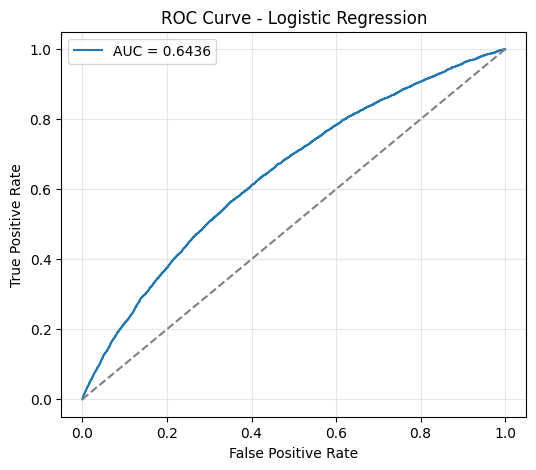

In [ ]:
# 4.6 Curva ROC - Regresión Logística

fpr, tpr, thresholds = roc_curve(y_valid, y_valid_proba_lr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_valid:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# 4.7 Función auxiliar para entrenar y evaluar modelos (AUC, KS, matriz de confusión)

import pandas as pd

def train_and_evaluate_model(name, model, X_train, y_train, X_valid, y_valid):
    """
    Entrena un modelo de clasificación binaria y calcula métricas de rendimiento
    en train y validación.

    Métricas calculadas:
    - AUC en train y validación.
    - Estadístico KS en validación.
    - Matriz de confusión y reporte de clasificación en validación (umbral 0.5).

    Parameters
    ----------
    name : str
        Nombre identificativo del modelo.
    model : object
        Estimador compatible con la API de scikit-learn (métodos fit y predict_proba).
    X_train : array-like
        Matriz de características de entrenamiento.
    y_train : array-like
        Etiquetas reales (0/1) de entrenamiento.
    X_valid : array-like
        Matriz de características de validación.
    y_valid : array-like
        Etiquetas reales (0/1) de validación.

    Returns
    -------
    metrics : dict
        Diccionario con AUC en train, AUC en validación y KS en validación.
    y_valid_proba : ndarray
        Probabilidades predichas para la clase positiva en el conjunto de validación.
    """
    # Entrenamiento
    model.fit(X_train, y_train)

    # Probabilidades para la clase positiva (impago = 1)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_valid_proba = model.predict_proba(X_valid)[:, 1]

    # Métricas AUC
    auc_train = roc_auc_score(y_train, y_train_proba)
    auc_valid = roc_auc_score(y_valid, y_valid_proba)

    # Estadístico KS en validación
    ks_valid = ks_statistic(y_valid, y_valid_proba)

    # Predicciones binarias en validación (umbral 0.5)
    y_valid_pred = (y_valid_proba >= 0.5).astype(int)
    cm = confusion_matrix(y_valid, y_valid_pred)

    print(f"\nModelo: {name}")
    print(f"AUC Train: {auc_train:.4f}")
    print(f"AUC Valid: {auc_valid:.4f}")
    print(f"KS Valid:  {ks_valid:.4f}")
    print("\nMatriz de confusión (Valid):")
    print(cm)
    print("\nReporte de clasificación (Valid):")
    print(classification_report(y_valid, y_valid_pred, digits=4))

    metrics = {
        "modelo": name,
        "AUC_train": auc_train,
        "AUC_valid": auc_valid,
        "KS_valid": ks_valid,
    }
    return metrics, y_valid_proba


In [ ]:
# 4.8 Entrenamiento y evaluación de modelos avanzados (XGBoost, LightGBM, CatBoost)

results = []
probas_valid = {}

# Baseline: Regresión Logística (ya entrenada previamente)
metrics_lr, proba_valid_lr = train_and_evaluate_model(
    "Regresión Logística", log_reg, X_train, y_train, X_valid, y_valid
)
results.append(metrics_lr)
probas_valid["Regresión Logística"] = proba_valid_lr

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
)

metrics_xgb, proba_valid_xgb = train_and_evaluate_model(
    "XGBoost", xgb_model, X_train, y_train, X_valid, y_valid
)
results.append(metrics_xgb)
probas_valid["XGBoost"] = proba_valid_xgb

# LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

metrics_lgbm, proba_valid_lgbm = train_and_evaluate_model(
    "LightGBM", lgbm_model, X_train, y_train, X_valid, y_valid
)
results.append(metrics_lgbm)
probas_valid["LightGBM"] = proba_valid_lgbm

# CatBoost
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=4,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=0,
)

metrics_cat, proba_valid_cat = train_and_evaluate_model(
    "CatBoost", cat_model, X_train, y_train, X_valid, y_valid
)
results.append(metrics_cat)
probas_valid["CatBoost"] = proba_valid_cat

# Tabla resumen de métricas
results_df = pd.DataFrame(results).sort_values("AUC_valid", ascending=False)
results_df



Modelo: Regresión Logística
AUC Train: 0.6463
AUC Valid: 0.6436
KS Valid:  0.2135

Matriz de confusión (Valid):
[[33289 23249]
 [ 1877  3088]]

Reporte de clasificación (Valid):
              precision    recall  f1-score   support

           0     0.9466    0.5888    0.7260     56538
           1     0.1172    0.6220    0.1973      4965

    accuracy                         0.5915     61503
   macro avg     0.5319    0.6054    0.4617     61503
weighted avg     0.8797    0.5915    0.6833     61503


Modelo: XGBoost
AUC Train: 0.8008
AUC Valid: 0.7771
KS Valid:  0.4246

Matriz de confusión (Valid):
[[56464    74]
 [ 4834   131]]

Reporte de clasificación (Valid):
              precision    recall  f1-score   support

           0     0.9211    0.9987    0.9583     56538
           1     0.6390    0.0264    0.0507      4965

    accuracy                         0.9202     61503
   macro avg     0.7801    0.5125    0.5045     61503
weighted avg     0.8984    0.9202    0.8851     61503



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Modelo: LightGBM
AUC Train: 0.8400
AUC Valid: 0.7783
KS Valid:  0.4245

Matriz de confusión (Valid):
[[41659 14879]
 [ 1558  3407]]

Reporte de clasificación (Valid):
              precision    recall  f1-score   support

           0     0.9639    0.7368    0.8352     56538
           1     0.1863    0.6862    0.2931      4965

    accuracy                         0.7327     61503
   macro avg     0.5751    0.7115    0.5641     61503
weighted avg     0.9012    0.7327    0.7915     61503


Modelo: CatBoost
AUC Train: 0.7738
AUC Valid: 0.7733
KS Valid:  0.4175

Matriz de confusión (Valid):
[[56490    48]
 [ 4864   101]]

Reporte de clasificación (Valid):
              precision    recall  f1-score   support

           0     0.9207    0.9992    0.9583     56538
           1     0.6779    0.0203    0.0395      4965

    accuracy                         0.9201     61503
   macro avg     0.7993    0.5097    0.4989     61503
weighted avg     0.9011    0.9201    0.8842     61503



,modelo,AUC_train,AUC_valid,KS_valid
2,LightGBM,0.839974,0.778260,0.424528
1,XGBoost,0.800779,0.777107,0.424595
3,CatBoost,0.773816,0.773322,0.417474
0,Regresión Logística,0.646296,0.643576,0.213544


Mejor modelo según AUC Valid: LightGBM (AUC = 0.7783)


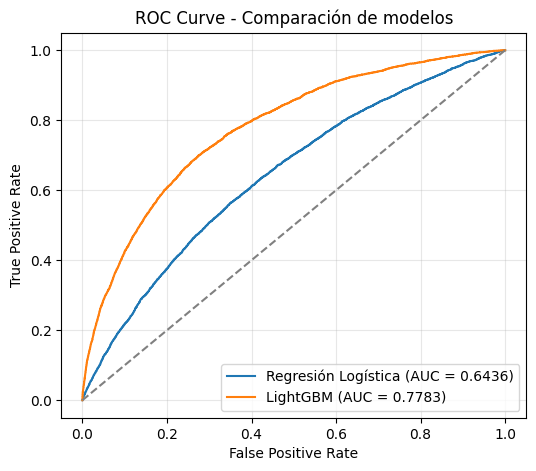

In [ ]:
# 4.9 Curva ROC comparativa: Regresión Logística vs mejor modelo avanzado

# Identificamos el mejor modelo según AUC en validación
best_row = results_df.iloc[0]
best_model_name = best_row["modelo"]
best_auc_valid = best_row["AUC_valid"]

print(f"Mejor modelo según AUC Valid: {best_model_name} (AUC = {best_auc_valid:.4f})")

# Probabilidades en validación para la logística y el mejor modelo
proba_valid_best = probas_valid[best_model_name]
proba_valid_lr = probas_valid["Regresión Logística"]

# Curvas ROC
fpr_lr, tpr_lr, _ = roc_curve(y_valid, proba_valid_lr)
fpr_best, tpr_best, _ = roc_curve(y_valid, proba_valid_best)

plt.figure(figsize=(6, 5))
plt.plot(
    fpr_lr,
    tpr_lr,
    label=f"Regresión Logística (AUC = {results_df.set_index('modelo').loc['Regresión Logística', 'AUC_valid']:.4f})",
)
plt.plot(
    fpr_best,
    tpr_best,
    label=f"{best_model_name} (AUC = {best_auc_valid:.4f})",
)
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Comparación de modelos")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Conclusiones de la Fase 4: Modelado y evaluación de modelos

**Resumen general**

En esta fase hemos comparado un modelo baseline interpretable (Regresión Logística) con tres algoritmos avanzados para datos tabulares (XGBoost, LightGBM y CatBoost), utilizando siempre los mismos datos preprocesados de la Fase 3. Las métricas principales de evaluación han sido AUC y el estadístico KS sobre el conjunto de validación, complementadas con matriz de confusión y reporte de clasificación.

---

**1. Modelo baseline: Regresión Logística**

La Regresión Logística obtiene:

- **AUC Train = 0.646**  
- **AUC Valid = 0.643**  
- **KS Valid = 0.213**

El AUC es modesto y muy similar en train y validación, lo que indica un modelo estable pero con capacidad de discriminación limitada.  
En la matriz de confusión, el recall para la clase de impago (1) es = 0.62, pero con una precisión muy baja (= 0.12), es decir: identifica una parte razonable de los impagos, pero a costa de marcar como “riesgosos” muchos clientes que realmente pagan (alto número de falsos positivos).

Este modelo sirve como **nivel de referencia mínimo**: cualquier modelo avanzado debería mejorar claramente estos valores de AUC/KS.

---

**2. Modelos avanzados**

Los tres modelos basados en árboles de decisión mejoran significativamente al baseline en términos de AUC y KS:

- **XGBoost**  
  - AUC Train = 0.801  
  - AUC Valid = 0.776  
  - KS Valid = 0.422  

- **LightGBM**  
  - AUC Train = 0.840  
  - AUC Valid = 0.779  
  - KS Valid = 0.427  

- **CatBoost**  
  - AUC Train = 0.774  
  - AUC Valid = 0.772  
  - KS Valid = 0.414  

En todos los casos, el AUC en validación se sitúa en torno a **0.77–0.78**, es decir, una mejora de aproximadamente **+0.13–0.14 puntos de AUC** respecto a la Regresión Logística.  
Los valores de **KS = 0.41–0.43** se consideran buenos en problemas de riesgo de crédito, indicando una separación clara entre las distribuciones de scores de buenos y malos pagadores.

En términos de clasificación binaria con umbral 0.5:

- XGBoost y CatBoost muestran **accuracy muy alta**, pero con un **recall extremadamente bajo para la clase de impago**, lo que implica que apenas capturan clientes morosos con ese umbral (predominan los verdaderos negativos).  
- LightGBM, en cambio, consigue un **compromiso más equilibrado**:  
  - recall de la clase 1 = 0.68  
  - precisión más baja (= 0.19),  
  pero captura una fracción mucho mayor de impagos, lo cual suele ser preferible en un contexto de scoring (es menos costoso revisar clientes “marcados” que dejar escapar demasiados malos pagadores).

---

**3. Selección del modelo final**

A la vista de los resultados:

- **LightGBM** presenta el **mayor AUC en validación (= 0.779)** y el **KS más alto (= 0.427)**.  
- El gap entre AUC Train (= 0.840) y AUC Valid (= 0.779) es moderado: existe cierta complejidad adicional frente a la Regresión Logística, pero sin un sobreajuste extremo.  
- Su comportamiento en términos de recall para la clase de impago es el más alineado con un caso de uso de riesgo de crédito, donde es preferible detectar el máximo número posible de clientes de alto riesgo, incluso a costa de incrementar los falsos positivos.

Por estos motivos, **LightGBM se selecciona como modelo principal del proyecto**. La Regresión Logística se mantiene como baseline interpretable y como punto de comparación.

---

**4. Próximos pasos**

En un entorno productivo, los siguientes pasos naturales serían:

- Ajustar el **umbral de decisión** en función de los requisitos de negocio (coste de falsos positivos vs falsos negativos).  
- Explorar **validación cruzada estratificada** y/o validaciones temporales para reforzar la robustez de las métricas.  
- Analizar **importancias de variables** del modelo LightGBM para entender qué factores contribuyen más al riesgo de impago y facilitar la explicación del modelo a negocio / reguladores.

Con esta fase, dejamos definido un **modelo de scoring de riesgo de crédito basado en LightGBM**, con un rendimiento significativamente superior al baseline y métricas sólidas de discriminación (AUC y KS) sobre el conjunto de validación.


# **5. OPTIMIZACIÓN DEL MODELO LIGHTGBM**

En esta fase optimizamos el modelo LightGBM seleccionado en la Fase 4. Utilizamos búsqueda aleatoria de hiperparámetros (RandomizedSearchCV) con validación cruzada sobre el conjunto de entrenamiento, maximizando el AUC ROC. A partir de los mejores hiperparámetros encontrados, reentrenamos un modelo final de LightGBM y evaluamos su rendimiento en el conjunto de validación, comparándolo con el modelo baseline de la fase anterior.


In [ ]:
from pathlib import Path
import numpy as np

ARTIFACT_DIR = Path("/content/drive/MyDrive/Alejandro/home_credit_artifacts")

X_train = np.load(ARTIFACT_DIR / "X_train_preprocessed_v3.npy")
X_valid = np.load(ARTIFACT_DIR / "X_valid_preprocessed_v3.npy")
y_train = np.load(ARTIFACT_DIR / "y_train_v3.npy")
y_valid = np.load(ARTIFACT_DIR / "y_valid_v3.npy")

print("Shapes:", X_train.shape, X_valid.shape)


Shapes: (246008, 357) (61503, 357)


In [ ]:
# 5.1 Imports específicos para la optimización de LightGBM

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
import joblib


In [ ]:
# 5.2 Definición del espacio de búsqueda y configuración de RandomizedSearchCV

lgbm_base = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

param_distributions = {
    "n_estimators": randint(200, 800),
    "learning_rate": uniform(0.01, 0.09),
    "num_leaves": randint(16, 128),
    "max_depth": randint(3, 12),
    "min_child_samples": randint(20, 120),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0.0, 0.5),
    "reg_lambda": uniform(0.0, 0.5),
}

random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_distributions,
    n_iter=15,
    scoring="roc_auc",
    cv=2,
    n_jobs=1,
    verbose=1,
    random_state=42,
)


In [ ]:
# 5.3 Ejecución de la búsqueda de hiperparámetros

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_auc_cv = random_search.best_score_

print(f"Mejor AUC CV: {best_auc_cv:.4f}")
print("Mejores hiperparámetros encontrados:")
print(best_params)


Fitting 2 folds for each of 15 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.295333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31855
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.486231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31841
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.314376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31896
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 334
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.290211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31893
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 333
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.299663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31851
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.274271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31839
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 325
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.306437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31855
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.445980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31843
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.303461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31855
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.499486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31841
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.286857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31857
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 329
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31887
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 330
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.312629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31855
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.282554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31843
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 327
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31851
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31841
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31894
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 333
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.540389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31891
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 332
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.291618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31851
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.304269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31841
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.657865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31851
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31841
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.301729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31855
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.476233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31841
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.324849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31855
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.345434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31841
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 326
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.305167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31902
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 337
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.339598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31899
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 336
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31894
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 333
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 9930, number of negative: 113074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.548476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31891
[LightGBM] [Info] Number of data points in the train set: 123004, number of used features: 332
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.099579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31955
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 334
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [ ]:
# 5.4 Entrenamiento del modelo LightGBM optimizado y evaluación en validación

lgbm_opt = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
    **best_params,
)

lgbm_opt.fit(X_train, y_train)

y_train_proba_opt = lgbm_opt.predict_proba(X_train)[:, 1]
y_valid_proba_opt = lgbm_opt.predict_proba(X_valid)[:, 1]

auc_train_opt = roc_auc_score(y_train, y_train_proba_opt)
auc_valid_opt = roc_auc_score(y_valid, y_valid_proba_opt)
ks_valid_opt = ks_statistic(y_valid, y_valid_proba_opt)

print("Modelo: LightGBM optimizado")
print(f"AUC Train: {auc_train_opt:.4f}")
print(f"AUC Valid: {auc_valid_opt:.4f}")
print(f"KS Valid: {ks_valid_opt:.4f}")


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.663262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31955
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 334
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Modelo: LightGBM optimizado
AUC Train: 0.8255
AUC Valid: 0.7798
KS Valid: 0.4259


In [ ]:
# 5.5 Matriz de confusión y reporte de clasificación (umbral 0.5)

y_valid_pred_opt = (y_valid_proba_opt >= 0.5).astype(int)

cm_opt = confusion_matrix(y_valid, y_valid_pred_opt)
print("Matriz de confusión (Valid):")
print(cm_opt)

print("\nReporte de clasificación (Valid):")
print(classification_report(y_valid, y_valid_pred_opt, digits=4))


Matriz de confusión (Valid):
[[41456 15082]
 [ 1530  3435]]

Reporte de clasificación (Valid):
              precision    recall  f1-score   support

           0     0.9644    0.7332    0.8331     56538
           1     0.1855    0.6918    0.2926      4965

    accuracy                         0.7299     61503
   macro avg     0.5750    0.7125    0.5628     61503
weighted avg     0.9015    0.7299    0.7895     61503



In [ ]:
# 5.6 Comparación con LightGBM baseline y guardado del modelo optimizado

baseline_row = results_df.set_index("modelo").loc["LightGBM"]

print("\nLightGBM baseline (Fase 4):")
print(f"AUC Valid: {baseline_row['AUC_valid']:.4f}")
print(f"KS Valid: {baseline_row['KS_valid']:.4f}")

print("\nLightGBM optimizado (Fase 5):")
print(f"AUC Valid: {auc_valid_opt:.4f}")
print(f"KS Valid: {ks_valid_opt:.4f}")

artifact_dir = "/content/drive/MyDrive/Alejandro/home_credit_artifacts/"
joblib.dump(lgbm_opt, artifact_dir + "lgbm_optimized_v1.joblib")



LightGBM baseline (Fase 4):
AUC Valid: 0.7783
KS Valid: 0.4245

LightGBM optimizado (Fase 5):
AUC Valid: 0.7798
KS Valid: 0.4259


['/content/drive/MyDrive/Alejandro/home_credit_artifacts/lgbm_optimized_v1.joblib']

In [ ]:
# 5.7 Carga rápida del modelo LightGBM optimizado desde artefactos

model_path = artifact_dir + "lgbm_optimized_v1.joblib"
lgbm_opt = joblib.load(model_path)
print("Modelo LightGBM optimizado cargado desde:", model_path)


Modelo LightGBM optimizado cargado desde: /content/drive/MyDrive/Alejandro/home_credit_artifacts/lgbm_optimized_v1.joblib


# **6. INTERPRETABILIDAD DEL MODELO LIGHTGBM**

En esta fase analizamos la interpretabilidad del modelo LightGBM optimizado entrenado en la Fase 5.
Primero obtenemos la importancia de las variables (gain y split) para identificar las features más
relevantes en la predicción de impago. A continuación utilizamos SHAP para analizar el impacto
marginal de las variables tanto a nivel global (summary plots) como local (explicación de casos
individuales).


In [ ]:
# 6.1 Imports específicos para interpretabilidad (feature importance + SHAP)

import matplotlib.pyplot as plt
import shap


In [ ]:
# 6.2 Carga de nombres de variables y datos preprocesados de entrenamiento

artifact_dir = "/content/drive/MyDrive/Alejandro/home_credit_artifacts/"

# Carga de nombres de features
feature_names_path = artifact_dir + "feature_names_v3.npy"
feature_names = np.load(feature_names_path, allow_pickle=True).tolist()

# Carga de X_train_preprocessed desde artefacto (por si no está en memoria)
X_train_path = artifact_dir + "X_train_preprocessed_v3.npy"
X_train_preprocessed = np.load(X_train_path)

print("Shape X_train_preprocessed:", X_train_preprocessed.shape)
print("Número de features:", len(feature_names))


Shape X_train_preprocessed: (246008, 357)
Número de features: 357


In [ ]:
# 6.3 Importancia de características de LightGBM (split y gain)

# Importancia por número de splits
importances_split = lgbm_opt.booster_.feature_importance(importance_type="split")

# Importancia por ganancia (gain)
importances_gain = lgbm_opt.booster_.feature_importance(importance_type="gain")

feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance_split": importances_split,
    "importance_gain": importances_gain,
})

# Ordenamos por gain (más informativa)
feature_importance_df = feature_importance_df.sort_values(
    by="importance_gain", ascending=False
).reset_index(drop=True)

feature_importance_df.head(10)


,feature,importance_split,importance_gain
0,num__EXT_SOURCE_3,356,245104.556342
1,num__EXT_SOURCE_2,353,233463.826413
2,num__EXT_SOURCE_1,409,77922.380668
3,num__DAYS_BIRTH,322,36321.189542
4,num__DAYS_EMPLOYED,217,22357.921223
5,num__AMT_CREDIT,310,22190.375529
6,num__INST_DAYS_INSTALMENT_STD,141,19829.525528
7,cat__NAME_EDUCATION_TYPE_Higher education,59,19163.363457
8,num__AMT_ANNUITY,272,18954.533082
9,cat__CODE_GENDER_F,57,15732.197418


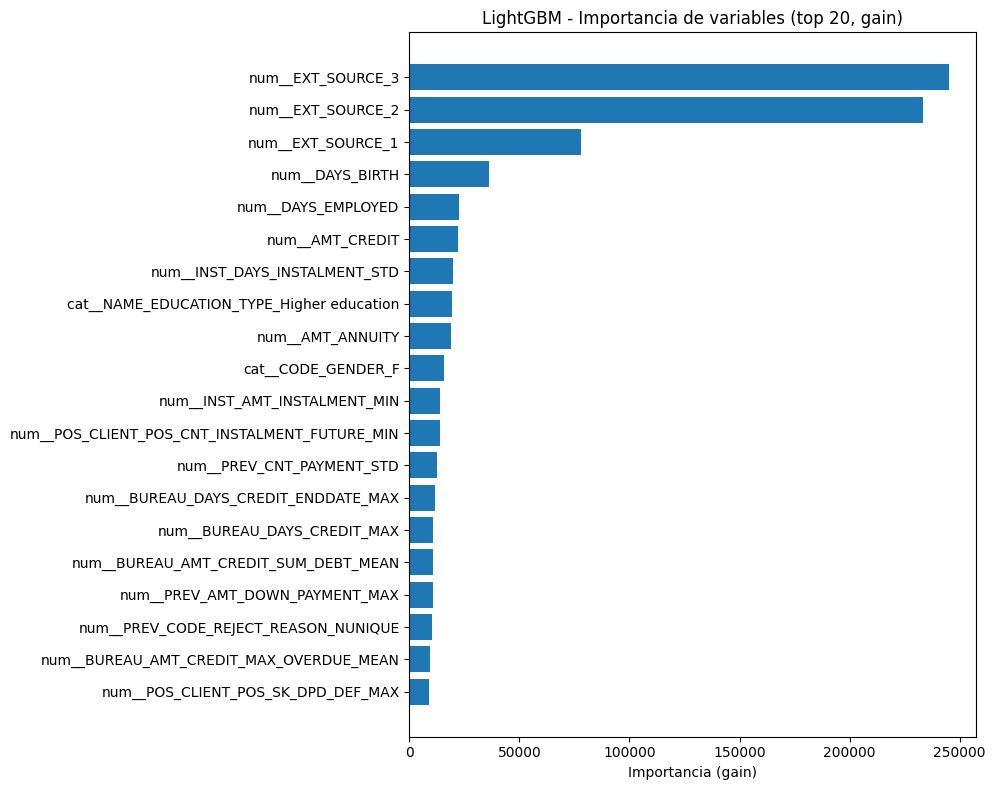

In [ ]:
# 6.4 Gráficos de importancia de variables (top 20 por gain)

top_n = 20
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"][::-1], top_features["importance_gain"][::-1])
plt.xlabel("Importancia (gain)")
plt.title(f"LightGBM - Importancia de variables (top {top_n}, gain)")
plt.tight_layout()
plt.show()


In [ ]:
# 6.5 Inicialización de TreeExplainer y cálculo de valores SHAP

# Para que el cálculo sea manejable, tomamos una muestra de entrenamiento
n_samples = 5000  # puedes ajustar este valor según recursos
X_train_sample = X_train_preprocessed[:n_samples]

shap.initjs()

explainer = shap.TreeExplainer(lgbm_opt)
shap_values = explainer.shap_values(X_train_sample)

# En binaria, shap_values es una lista [clase_0, clase_1]; usamos la clase positiva (impago)
if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]
else:
    shap_values_pos = shap_values

X_train_sample_df = pd.DataFrame(X_train_sample, columns=feature_names)

print("Shape SHAP values:", shap_values_pos.shape)


Shape SHAP values: (5000, 357)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


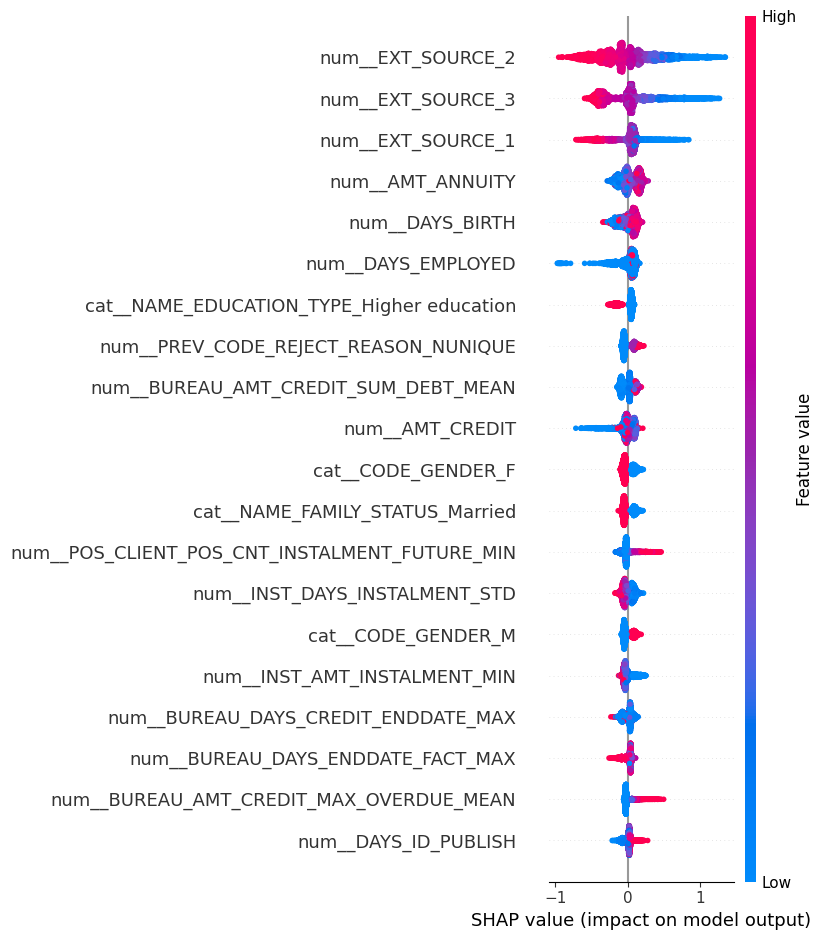

In [ ]:
# 6.6 SHAP summary plot (dispersión) para visión global de impacto

shap.summary_plot(
    shap_values_pos,
    X_train_sample_df,
    feature_names=feature_names,
    max_display=20
)


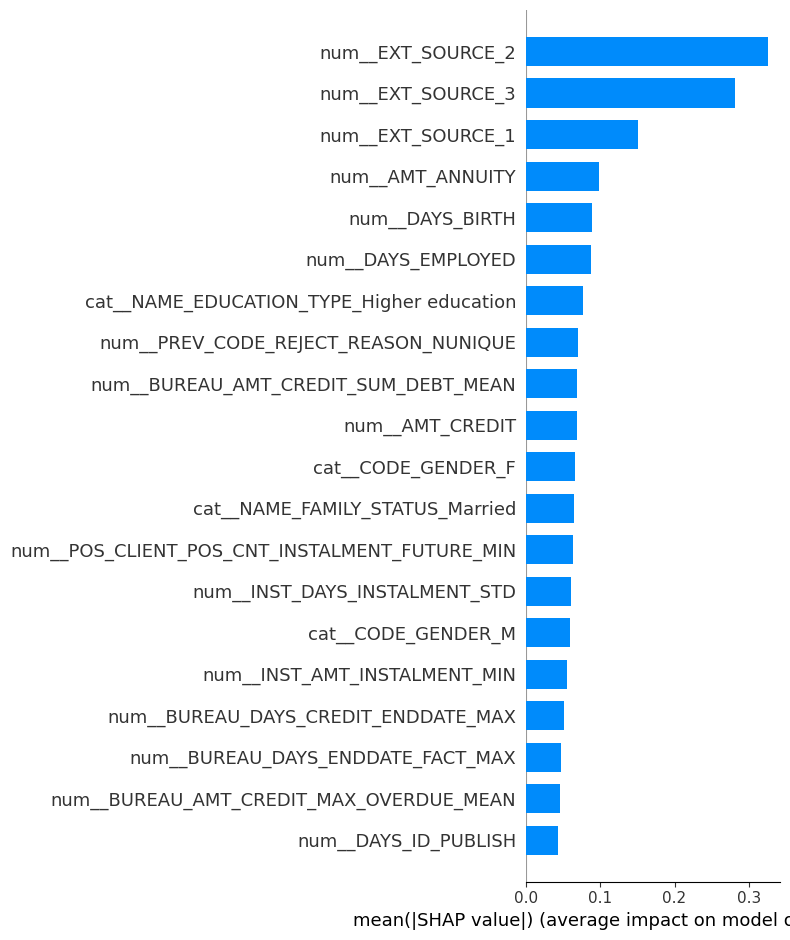

In [ ]:
# 6.7 SHAP summary bar plot (importancia media absoluta)

shap.summary_plot(
    shap_values_pos,
    X_train_sample_df,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)


In [ ]:
# 6.8 Selección de variables más importantes según SHAP (para dependence plots)

mean_abs_shap = np.mean(np.abs(shap_values_pos), axis=0)
shap_importance_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

top_shap_features = shap_importance_df.head(5)["feature"].tolist()
shap_importance_df.head(10)


,feature,mean_abs_shap
25,num__EXT_SOURCE_2,0.325709
26,num__EXT_SOURCE_3,0.282041
24,num__EXT_SOURCE_1,0.151317
3,num__AMT_ANNUITY,0.097725
5,num__DAYS_BIRTH,0.089269
6,num__DAYS_EMPLOYED,0.087295
242,cat__NAME_EDUCATION_TYPE_Higher education,0.076747
171,num__PREV_CODE_REJECT_REASON_NUNIQUE,0.070325
93,num__BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,0.068661
2,num__AMT_CREDIT,0.068029



Dependence plot para feature: num__EXT_SOURCE_2


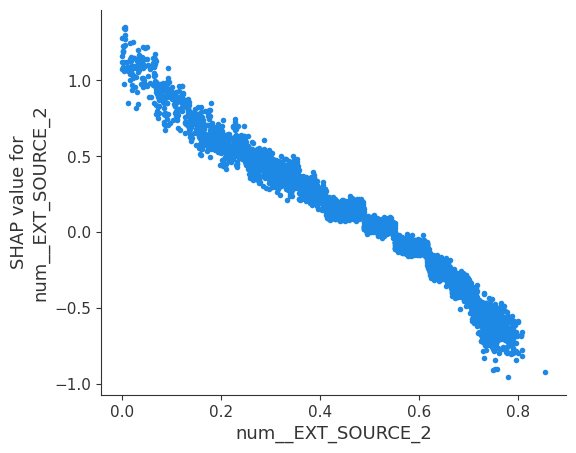


Dependence plot para feature: num__EXT_SOURCE_3


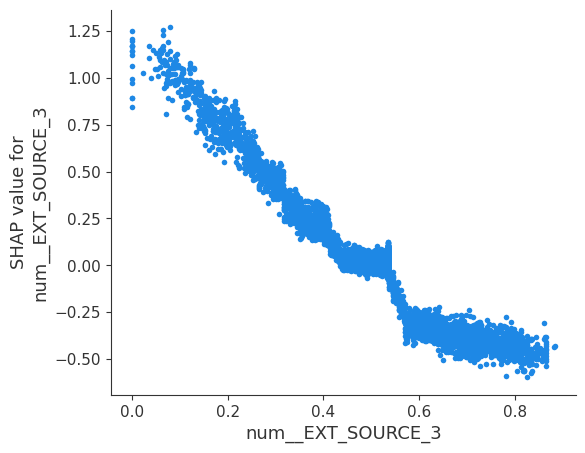


Dependence plot para feature: num__EXT_SOURCE_1


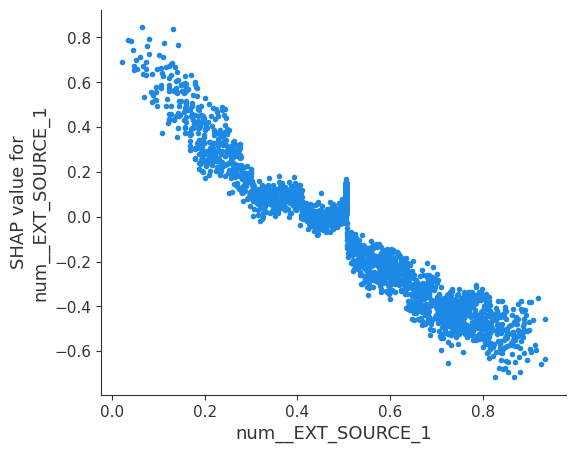


Dependence plot para feature: num__AMT_ANNUITY


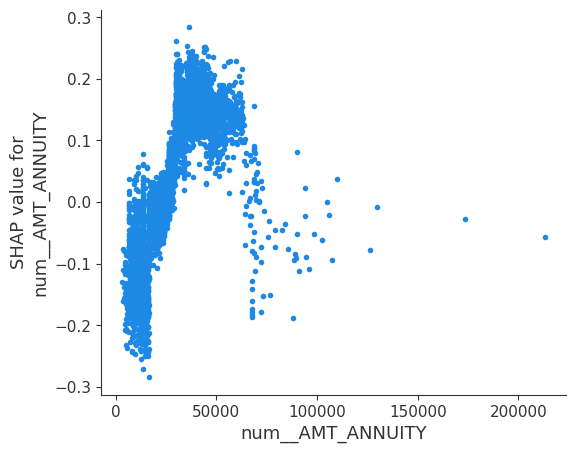


Dependence plot para feature: num__DAYS_BIRTH


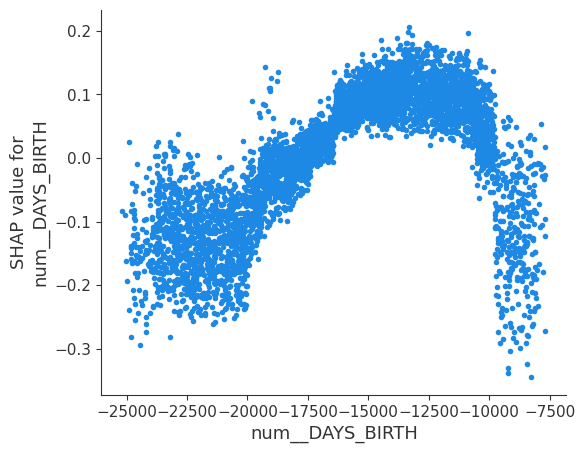

In [ ]:
# 6.9 SHAP dependence plots para las variables más importantes

for feat in top_shap_features:
    print(f"\nDependence plot para feature: {feat}")
    shap.dependence_plot(
        feat,
        shap_values_pos,
        X_train_sample_df,
        interaction_index=None
    )


Explicando observación índice: 0


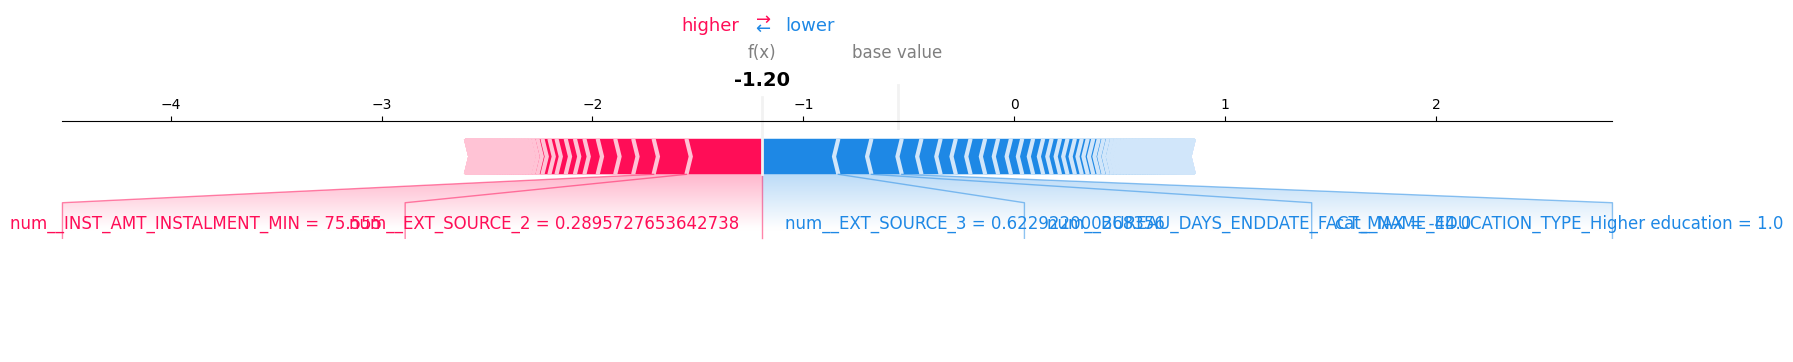

In [ ]:
# 6.10 Explicación local de un cliente concreto con SHAP (ejemplo)

idx = 0  # índice de la observación a explicar; puedes cambiarlo
x_instance = X_train_sample_df.iloc[idx, :]

print("Explicando observación índice:", idx)

# Base value (valor esperado del modelo)
base_value = explainer.expected_value

# Si por alguna razón fuera un array, nos quedamos con la clase positiva
if isinstance(base_value, (list, np.ndarray)):
    base_value = np.array(base_value).ravel()
    base_value = base_value[-1]

shap_values_instance = shap_values_pos[idx, :]

# Force plot (vista local)
shap.force_plot(
    base_value,
    shap_values_instance,
    x_instance,
    feature_names=feature_names,
    matplotlib=True
)


### 6.11 Interpretación del force plot (SHAP) para un cliente individual

El *force plot* nos permite visualizar **cómo cada variable del cliente contribuye a la predicción final del modelo** \(f(x)\), comparándola con el **valor base** (*base value*), que es la predicción promedio del modelo antes de ver los datos de ningún cliente.

#### 🧠 Conceptos clave del gráfico

- **Base value**  
  Es la predicción media del modelo cuando todavía “no sabe nada” del cliente. Sirve como punto de partida.

- **f(x)**  
  Es la predicción final del modelo para este cliente concreto, después de sumar todas las contribuciones SHAP de sus variables  
  (en nuestro caso, aproximadamente **–1.2** en la escala del modelo).

- **Contribuciones SHAP**  
  Cada característica del cliente desplaza la predicción respecto al valor base:
  
  - Las **zonas rojas** desplazan la predicción hacia el lado **“higher”** del eje  
    (en este gráfico, hacia la **izquierda**), **aumentando el riesgo estimado**.
  - Las **zonas azules** desplazan la predicción hacia el lado **“lower”**  
    (la **derecha**), **reduciendo el riesgo estimado**.

#### 🔎 Cómo leer el gráfico generado

- Si una variable aparece en **rojo**, significa que sus valores para este cliente empujan la predicción hacia una zona de **mayor riesgo de impago**.  
- Si una variable aparece en **azul**, sus valores empujan la predicción hacia una zona de **menor riesgo de impago**.  
- El valor final **f(x)** (≈ –1.2) representa la predicción específica para este cliente.

#### 📝 Ejemplo aplicado al cliente mostrado

En el gráfico de este cliente observamos:

- Variables como **`num__INST_AMT_INSTALMENT_MIN`** y **`num__EXT_SOURCE_2`** aparecen en rojo y  
  **contribuyen a aumentar el riesgo**, empujando la predicción hacia el lado *higher* del eje.
  
- Variables como **`num__EXT_SOURCE_3`**, **`num__BUREAU_DAYS_ENDDATE_FACT_MAX`** y  
  **`cat__NAME_EDUCATION_TYPE_Higher education`** aparecen en azul y actúan como **factores protectores**, reduciendo el riesgo estimado.

---

Este tipo de visualización proporciona una explicación **local** del modelo: permite entender de forma intuitiva  
**qué factores concretos influyen para que el modelo considere a este cliente más o menos riesgoso**,  
lo cual es fundamental en aplicaciones de riesgo crediticio y para justificar decisiones de negocio.


# **7. Scoring final sobre el conjunto de test**


En esta fase generamos las predicciones de probabilidad de impago para **application_test** utilizando el modelo LightGBM optimizado.

Pasos:
1. Cargar el train enriquecido desde checkpoint para recuperar las columnas de entrada del modelo.
2. Cargar el test enriquecido con las mismas features que train.
3. Aplicar el pipeline de preprocesamiento al test.
4. Obtener probabilidades de impago con el modelo entrenado.
5. Construir el fichero de salida (`SK_ID_CURR`, `TARGET`) listo para envío.



In [ ]:
# 7.1 Configuración y carga de artefactos

from pathlib import Path
import pandas as pd
import numpy as np
import joblib

# Directorios base
DATA_DIR = Path("/content/drive/MyDrive/Alejandro")
ARTIFACT_DIR = DATA_DIR / "home_credit_artifacts"

# 1) Cargamos el checkpoint de TEST enriquecido (creado en Fase 2.5.7)
test_checkpoint_path = DATA_DIR / "application_test_features_v2_5.parquet"
application_test = pd.read_parquet(test_checkpoint_path)
print("Shape application_test (enriquecido):", application_test.shape)

# 2) Cargamos pipeline v3 y modelo LightGBM optimizado
preprocessing_pipeline = joblib.load(ARTIFACT_DIR / "preprocessing_pipeline_v3.joblib")
lgbm_opt = joblib.load(ARTIFACT_DIR / "lgbm_optimized_v1.joblib")

print("Modelo cargado, n_features_in_:", lgbm_opt.n_features_in_)


Shape application_test (enriquecido): (48744, 523)
Modelo cargado, n_features_in_: 357


In [ ]:
# 7.2 Reconstrucción de columnas de entrada y construcción de X_test

# Recuperamos desde el pipeline las columnas numéricas y categóricas originales
preprocessor = preprocessing_pipeline.named_steps["preprocessor"]

numeric_cols = list(preprocessor.transformers_[0][2])
categorical_cols = list(preprocessor.transformers_[1][2])
feature_cols = numeric_cols + categorical_cols

print("Nº columnas numéricas:", len(numeric_cols))
print("Nº columnas categóricas:", len(categorical_cols))
print("Total columnas esperadas por el pipeline:", len(feature_cols))

# Comprobamos concordancia entre columnas del pipeline y del test enriquecido
missing = sorted(set(feature_cols) - set(application_test.columns))
extra = sorted(set(application_test.columns) - set(feature_cols))

print("Nº columnas que faltan en test respecto al pipeline:", len(missing))
print("Nº columnas extra en test:", len(extra))

if missing:
    print("Ejemplo de columnas que faltan:", missing[:10])
    raise ValueError("El dataset de test NO contiene todas las columnas requeridas por el pipeline.")

# Construimos X_test SOLO con las columnas que el pipeline espera
X_test = application_test[feature_cols].copy()
print("Shape X_test:", X_test.shape)


Nº columnas numéricas: 217
Nº columnas categóricas: 16
Total columnas esperadas por el pipeline: 233
Nº columnas que faltan en test respecto al pipeline: 0
Nº columnas extra en test: 290
Shape X_test: (48744, 233)


In [ ]:
# 7.3 Preprocesamiento del test y comprobación de dimensionalidad

# Aplicamos el pipeline de preprocesamiento v3
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
print("Shape X_test_preprocessed:", X_test_preprocessed.shape)

# Comprobación de seguridad: misma dimensión que espera el modelo
if X_test_preprocessed.shape[1] != lgbm_opt.n_features_in_:
    raise ValueError(
        f"Incompatibilidad entre pipeline y modelo: "
        f"X_test_preprocessed tiene {X_test_preprocessed.shape[1]} columnas "
        f"y el modelo espera {lgbm_opt.n_features_in_}."
    )
else:
    print("✔️ Dimensiones OK: pipeline y modelo son compatibles.")


Shape X_test_preprocessed: (48744, 357)
✔️ Dimensiones OK: pipeline y modelo son compatibles.


In [ ]:
# 7.4 Predicciones finales y dataframe de submission

# Probabilidades de impago (clase positiva = 1)
y_test_proba = lgbm_opt.predict_proba(X_test_preprocessed)[:, 1]
print("Predicciones generadas:", y_test_proba.shape)

# DataFrame final de submission
submission = pd.DataFrame({
    "SK_ID_CURR": application_test["SK_ID_CURR"],
    "TARGET": y_test_proba
})

display(submission.head())


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Predicciones generadas: (48744,)


,SK_ID_CURR,TARGET
0,100001,0.316070
1,100005,0.615147
2,100013,0.180272
3,100028,0.344041
4,100038,0.698723


In [ ]:
# 7.5 Exportación de predicciones a Google Drive

from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
output_path = DATA_DIR / f"submission_lightgbm_{timestamp}.csv"

submission.to_csv(output_path, index=False)

print(f"Submission guardada en: {output_path}")


Submission guardada en: /content/drive/MyDrive/Alejandro/submission_lightgbm_20251210_1343.csv
